# GoDaddy - Microbusiness Density Forecasting 

In [415]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
import datetime as dt
import itertools
import geopandas as gpd
import datetime as dt

from scipy.stats import linregress, spearmanr, kendalltau, median_abs_deviation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, RepeatedKFold, RandomizedSearchCV, GridSearchCV, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
# Walking window CV:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection._split import TimeSeriesSplit
from sklearn.metrics import make_scorer
# bayes opt
from bayes_opt import BayesianOptimization
# light gbm
import lightgbm as lgb
from lightgbm import LGBMRegressor
# catboost
from catboost import CatBoostRegressor
# grouped time series split
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)

In [451]:
# settings for forecasting
lag_list = [1,2,3]
lag_rolling_list = [1]
max_neighbors = 2
fourier_set = False
states_dummy = True
winsorize = True


# below should not be modified!
max_neighbors = max(min(max_neighbors, 2), 0)
neighb_list = list(range(1,max_neighbors+1))
lag_neigh_c = list(itertools.product(lag_list, neighb_list))

## Preprocessing data

In [279]:
train_df = pd.read_csv('data/train.csv')
train_df['year'] = [x.year for x in pd.to_datetime(train_df.first_day_of_month, format="%Y/%m/%d").astype('datetime64[Y]')]
train_df['year'] = train_df['year'].astype(int)
train_df.first_day_of_month = pd.to_datetime(train_df.first_day_of_month, format="%Y/%m/%d")
revealed_test_df = pd.read_csv('data/revealed_test.csv')
test_df = pd.read_csv('data/test.csv')
test_df['year'] = [x.year for x in pd.to_datetime(test_df.first_day_of_month, format="%Y/%m/%d").astype('datetime64[Y]')]
test_df['year'] = test_df['year'].astype(int)
test_df.first_day_of_month = pd.to_datetime(test_df.first_day_of_month, format="%Y/%m/%d")
census_starter = pd.read_csv('data/census_starter.csv', index_col=None)
pop_data = pd.read_csv('data/PopulationEstimates.csv', index_col=None, encoding='latin-1')

In [280]:
revealed_test_df['year'] = 2022

In [281]:
train_df = pd.concat([train_df, revealed_test_df])
test_df = test_df[~test_df['first_day_of_month'].isin(revealed_test_df['first_day_of_month'].unique())]

In [282]:
train_df = train_df.sort_values(['first_day_of_month', 'cfips'])
test_df = test_df.sort_values(['first_day_of_month', 'cfips'])

/tmp/ipykernel_2952/3809519405.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  train_df = train_df.sort_values(['first_day_of_month', 'cfips'])


In [283]:
test_df.shape

(18810, 4)

In [284]:
train_df.shape

(128535, 8)

In [285]:
train_df.sample(5, random_state=1)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year
28857,18089_2022-08-01,18089,Lake County,Indiana,2022-08-01 00:00:00,4.043347,15029,2022
3953,37179_2022-12-01,37179,Union County,North Carolina,2022-12-01,8.952792,15439,2022
85291,40117_2022-09-01,40117,Pawnee County,Oklahoma,2022-09-01 00:00:00,2.745192,344,2022
3561,34019_2022-12-01,34019,Hunterdon County,New Jersey,2022-12-01,11.672018,11778,2022
28411,18067_2021-03-01,18067,Howard County,Indiana,2021-03-01 00:00:00,2.986762,1902,2021


In [286]:
test_df.sample(5, random_state=1)

,row_id,cfips,first_day_of_month,year
11769,46013_2023-02-01,46013,2023-02-01,2023
8581,44007_2023-01-01,44007,2023-01-01,2023
22457,13259_2023-06-01,13259,2023-06-01,2023
18293,48199_2023-04-01,48199,2023-04-01,2023
24521,48115_2023-06-01,48115,2023-06-01,2023


In [287]:
test_df.isna().sum()

row_id                0
cfips                 0
first_day_of_month    0
year                  0
dtype: int64

In [288]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128535 entries, 0 to 6269
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 128535 non-null  object 
 1   cfips                  128535 non-null  int64  
 2   county                 128535 non-null  object 
 3   state                  128535 non-null  object 
 4   first_day_of_month     128535 non-null  object 
 5   microbusiness_density  128535 non-null  float64
 6   active                 128535 non-null  int64  
 7   year                   128535 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 8.8+ MB


In [289]:
train_df.groupby(['first_day_of_month'])['cfips'].count()

first_day_of_month
2019-08-01 00:00:00    3135
2019-09-01 00:00:00    3135
2019-10-01 00:00:00    3135
2019-11-01 00:00:00    3135
2019-12-01 00:00:00    3135
2020-01-01 00:00:00    3135
2020-02-01 00:00:00    3135
2020-03-01 00:00:00    3135
2020-04-01 00:00:00    3135
2020-05-01 00:00:00    3135
2020-06-01 00:00:00    3135
2020-07-01 00:00:00    3135
2020-08-01 00:00:00    3135
2020-09-01 00:00:00    3135
2020-10-01 00:00:00    3135
2020-11-01 00:00:00    3135
2020-12-01 00:00:00    3135
2021-01-01 00:00:00    3135
2021-02-01 00:00:00    3135
2021-03-01 00:00:00    3135
2021-04-01 00:00:00    3135
2021-05-01 00:00:00    3135
2021-06-01 00:00:00    3135
2021-07-01 00:00:00    3135
2021-08-01 00:00:00    3135
2021-09-01 00:00:00    3135
2021-10-01 00:00:00    3135
2021-11-01 00:00:00    3135
2021-12-01 00:00:00    3135
2022-01-01 00:00:00    3135
2022-02-01 00:00:00    3135
2022-03-01 00:00:00    3135
2022-04-01 00:00:00    3135
2022-05-01 00:00:00    3135
2022-06-01 00:00:00    3135
2

In [290]:
census_starter.shape

(3142, 26)

In [291]:
census_starter.sample(5, random_state=1)

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
1760,78.6,78.7,74.2,85.9,85.8,32029,16.4,20.4,21.8,23.2,...,4.7,5.2,7.2,7.2,7.1,63607,62284.0,66292,64000.0,66713.0
1735,68.8,74.5,75.4,77.2,77.7,31163,12.7,12.5,14.7,14.8,...,0.4,0.8,0.9,1.8,1.8,48704,51172.0,50781,53158.0,57579.0
1186,76.4,79.1,81.6,83.4,84.8,23019,16.7,17.2,17.5,17.7,...,1.7,1.6,1.8,1.5,1.4,47886,49374.0,50808,52128.0,55125.0
2803,83.3,84.9,86.5,87.8,88.9,49053,17.6,17.0,17.3,18.7,...,2.5,2.1,1.7,1.6,1.1,55175,56877.0,59839,61747.0,65040.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0


In [292]:
census_starter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pct_bb_2017            3142 non-null   float64
 1   pct_bb_2018            3142 non-null   float64
 2   pct_bb_2019            3142 non-null   float64
 3   pct_bb_2020            3141 non-null   float64
 4   pct_bb_2021            3141 non-null   float64
 5   cfips                  3142 non-null   int64  
 6   pct_college_2017       3142 non-null   float64
 7   pct_college_2018       3142 non-null   float64
 8   pct_college_2019       3142 non-null   float64
 9   pct_college_2020       3141 non-null   float64
 10  pct_college_2021       3141 non-null   float64
 11  pct_foreign_born_2017  3142 non-null   float64
 12  pct_foreign_born_2018  3142 non-null   float64
 13  pct_foreign_born_2019  3142 non-null   float64
 14  pct_foreign_born_2020  3141 non-null   float64
 15  pct_

### Census data

In [293]:
census_starter = pd.read_csv('data/census_starter.csv', index_col=None)
census_df = census_starter.melt(id_vars=['cfips'])
census_df['year'] = [int(x[-4:]) for x in census_df['variable']]
census_df['year'] = census_df['year'].astype(int)
census_df['variable'] = [x[:(len(x)-5)] for x in census_df['variable']]
census_df = census_df.pivot(index=['year','cfips'], columns=['variable'], values='value').reset_index()
census_df.year = census_df.year.astype(int)
census_df = census_df.ffill(axis = 0)

In [294]:
census_df.sample(5, random_state=1)

variable,year,cfips,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers
6097,2018,53005,65650.0,82.8,18.4,10.6,1.6
7467,2019,23013,57751.0,84.8,21.2,2.3,1.9
506,2017,13243,30640.0,60.7,6.9,2.0,0.3
1565,2017,29165,74199.0,87.5,25.6,5.6,3.0
470,2017,13169,55110.0,77.7,12.3,0.9,0.8


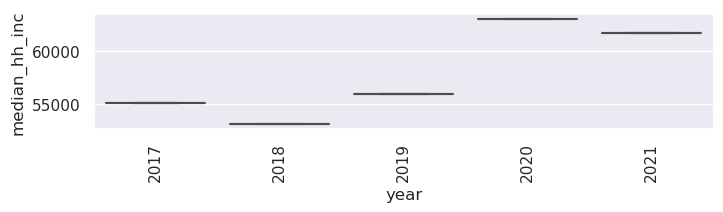

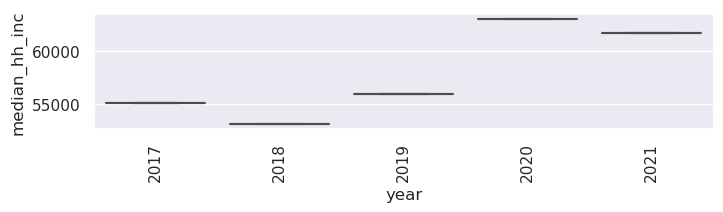

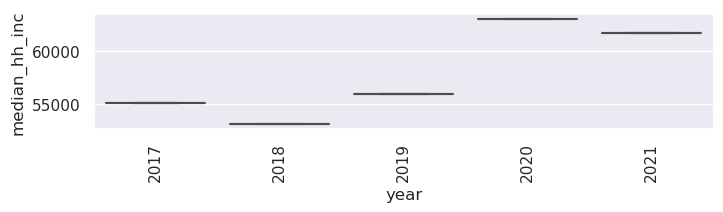

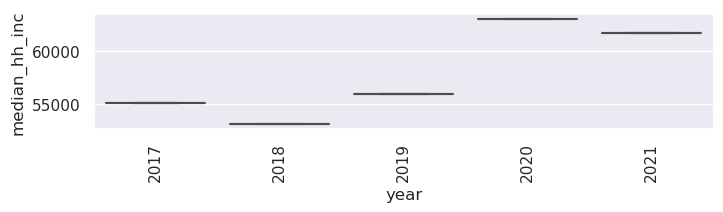

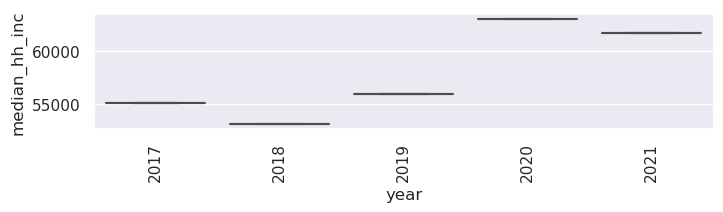

In [295]:
for column in census_df.drop('cfips', axis=1).columns[1:]:
    sns.set()
    fig, ax = plt.subplots()
    sns.boxplot(data = census_df[census_df.cfips==13169], x='year',y=('median_hh_inc'))
    fig.set_size_inches(8,1.5)
    for item in ax.get_xticklabels():
        item.set_rotation(90)

In [296]:
def forecast_per_group(col, year, cfips):
    _X=census_df[census_df.cfips == cfips]['year']
    _y=census_df[census_df.cfips == cfips][col]
    slope, intercept, _, _, _ = linregress(_X, _y)
    return intercept + year*slope

def forecast_array(df, col, year):
    return [forecast_per_group(col, year, cfips) for cfips in df.cfips]

def forecast_fill_df(df, year):
    df_return = df.copy()
    _column_list = census_df.columns[2:]
    for column in _column_list:
        df_return[column] = forecast_array(df, column, year)
    return df_return

In [297]:
census_2022 = pd.DataFrame(np.repeat(2022,len(census_df.cfips.unique())), columns=['year'])
census_2022['cfips'] = census_df.cfips.unique()

In [298]:
census_2022 = forecast_fill_df(census_2022, 2022)

In [299]:
census_2023 = pd.DataFrame(np.repeat(2023,len(census_df.cfips.unique())), columns=['year'])
census_2023['cfips'] = census_df.cfips.unique()
census_2023 = forecast_fill_df(census_2023, 2023)

In [300]:
census_df = census_df.append(census_2022, ignore_index = True).append(census_2023, ignore_index = True)

/tmp/ipykernel_2952/3864560008.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  census_df = census_df.append(census_2022, ignore_index = True).append(census_2023, ignore_index = True)


#### Merging

In [301]:
train_df = pd.merge(train_df, census_df, how='left', left_on=['cfips','year'], right_on=['cfips','year'])

In [302]:
test_df = pd.merge(test_df, census_df, how='left', left_on=['cfips','year'], right_on=['cfips','year'])
test_df = pd.merge(test_df, train_df[['cfips','county','state']], how='left', left_on=['cfips'], right_on=['cfips']).drop_duplicates()

### Entrepreneur survey
https://www.godaddy.com/ventureforward/microbusiness-datahub/

In [303]:
vf_data.cfips = vf_data.cfips.astype(int)

In [304]:
vf_data.head()

,cfips,county,state,groupflag,total_pop_20,orders_rank_aug19,orders_rank_sep19,orders_rank_oct19,orders_rank_nov19,orders_rank_dec19,...,avg_traffic_oct21,avg_traffic_nov21,avg_traffic_dec21,avg_traffic_jan22,avg_traffic_feb22,avg_traffic_mar22,avg_traffic_apr22,avg_traffic_may22,avg_traffic_jun22,avg_lifespan_mths
0,1001,Autauga,AL,30k - 225k pop,55639.0,668.0,511.0,723.0,624.0,1023.0,...,419.1,455.9,480.9,663.0,629.7,647.6,435.2,415.0,398.9,12.4
1,1003,Baldwin,AL,30k - 225k pop,218289.0,804.0,780.0,831.0,899.0,705.0,...,124.2,113.1,108.1,126.7,125.9,135.4,134.5,145.8,152.9,13.9
2,1005,Barbour,AL,< 30k pop,25026.0,1001.0,684.0,883.0,1118.0,1159.0,...,157.8,111.6,110.6,133.8,114.5,129.9,153.3,134.6,139.7,15.1
3,1007,Bibb,AL,< 30k pop,22374.0,123.0,96.0,113.0,199.0,195.0,...,132.2,124.7,113.1,101.9,69.3,74.4,65.1,69.6,91.1,14.8
4,1009,Blount,AL,30k - 225k pop,57755.0,65.0,108.0,203.0,121.0,313.0,...,62.8,70.8,70.9,95.8,67.5,64.8,84.7,108.3,88.4,14.8


In [305]:
vf_data_ts = vf_data.melt(id_vars=['cfips','county','state','groupflag'])
vf_data_ts = vf_data_ts[~vf_data_ts.variable.isin(['total_pop_20', 'avg_lifespan_mths'])]

In [306]:
vf_data_ts['year'] = [2000+int(x[-2:]) for x in vf_data_ts['variable']]
vf_data_ts['year'] = vf_data_ts['year'].astype(int)
vf_data_ts['variable'] = [x[:(len(x)-2)] for x in vf_data_ts['variable']]
vf_data_ts['month'] = [x[-3:] for x in vf_data_ts['variable']]
vf_data_ts['variable'] = [x[:(len(x)-4)] for x in vf_data_ts['variable']]

In [307]:
def date_converter(x):
    return dt.datetime.strptime(x['month']+' '+str(x['year']), '%b %Y').date()

In [308]:
vf_data_ts['first_day_of_month'] = vf_data_ts.apply(date_converter, axis=1)

In [309]:
vf_data_ts.head(3)

,cfips,county,state,groupflag,variable,value,year,month,first_day_of_month
3094,1001,Autauga,AL,30k - 225k pop,orders_rank,668.0,2019,aug,2019-08-01
3095,1003,Baldwin,AL,30k - 225k pop,orders_rank,804.0,2019,aug,2019-08-01
3096,1005,Barbour,AL,< 30k pop,orders_rank,1001.0,2019,aug,2019-08-01


In [310]:
vf_data_ts = vf_data_ts.drop(['year','month'], axis=1)

In [311]:
#vf_data = 
vf_data_ts = vf_data_ts.pivot_table(index=['cfips','county','state','groupflag','first_day_of_month'], columns=['variable'], values='value', aggfunc='sum').reset_index()
vf_data_ts.head()

variable,cfips,county,state,groupflag,first_day_of_month,avg_traffic,gmv_rank,merchants_rank,orders_rank,top3industries
0,1001,Autauga,AL,30k - 225k pop,2019-08-01,51.7,693.0,342.0,668.0,"fashion, beauty, homesvcs"
1,1001,Autauga,AL,30k - 225k pop,2019-09-01,49.4,396.0,550.0,511.0,"beauty, homesvcs"
2,1001,Autauga,AL,30k - 225k pop,2019-10-01,54.8,825.0,699.0,723.0,"beauty, fashion"
3,1001,Autauga,AL,30k - 225k pop,2019-11-01,47.1,571.0,491.0,624.0,"beauty, fashion, homesvcs"
4,1001,Autauga,AL,30k - 225k pop,2019-12-01,52.7,1026.0,777.0,1023.0,"beauty, homesvcs"


In [312]:
vf_data_ts.first_day_of_month.max()

datetime.date(2022, 6, 1)

In [313]:
vf_data_ts = vf_data_ts.drop(['county','state','groupflag','top3industries'], axis=1) 

In [314]:
vf_data_ts.isna().sum()

variable
cfips                 0
first_day_of_month    0
avg_traffic           0
gmv_rank              0
merchants_rank        0
orders_rank           0
dtype: int64

#### Merging
Note: since we only have data until June 2022, we merge only for the train data, and apply 12-month lagged values later

In [315]:
train_df.first_day_of_month = pd.DatetimeIndex(train_df.first_day_of_month)

In [316]:
def dt_to_date(x): return x['first_day_of_month'].date()
train_df.first_day_of_month = train_df.apply(dt_to_date, axis=1)

In [317]:
test_df.first_day_of_month = test_df.apply(dt_to_date, axis=1)

In [318]:
train_df = pd.merge(train_df, vf_data_ts, how='left', left_on=['cfips','first_day_of_month'], right_on=['cfips','first_day_of_month'])

----------------------
We handle missing values by imputing the median, by group:

In [319]:
train_df.drop('first_day_of_month', axis=1).isna().groupby(train_df.first_day_of_month).sum().reset_index().tail(10)

,first_day_of_month,row_id,cfips,county,state,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,avg_traffic,gmv_rank,merchants_rank,orders_rank
31,2022-03-01,0,0,0,0,0,0,0,0,0,0,0,0,50,50,50,50
32,2022-04-01,0,0,0,0,0,0,0,0,0,0,0,0,50,50,50,50
33,2022-05-01,0,0,0,0,0,0,0,0,0,0,0,0,50,50,50,50
34,2022-06-01,0,0,0,0,0,0,0,0,0,0,0,0,50,50,50,50
35,2022-07-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
36,2022-08-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
37,2022-09-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
38,2022-10-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
39,2022-11-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
40,2022-12-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135


In [320]:
vf_data_ts.columns[2:]

Index(['avg_traffic', 'gmv_rank', 'merchants_rank', 'orders_rank'], dtype='object', name='variable')

In [334]:
list_cols_with_na = train_df.isna().sum(0)[train_df.isna().sum(0)>0].index

In [335]:
col_group = ['first_day_of_month','state']
list_cols_with_na = train_df.isna().sum(0)[train_df.isna().sum(0)>0].index
for colname in list_cols_with_na:
    train_df[colname] = train_df.groupby(col_group, sort=False)[colname].transform(lambda x: x.median())

In [336]:
train_df.drop('first_day_of_month', axis=1).isna().groupby(train_df.first_day_of_month).sum().reset_index().tail(10)

,first_day_of_month,row_id,cfips,county,state,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,avg_traffic,gmv_rank,merchants_rank,orders_rank
31,2022-03-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32,2022-04-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,2022-05-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,2022-06-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35,2022-07-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
36,2022-08-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
37,2022-09-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
38,2022-10-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
39,2022-11-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
40,2022-12-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135


### Nearest 5 spatial neighbors

In [337]:
us_shape = gpd.read_file("data/us-county-boundaries.shp")

us_shape['fips'] = us_shape['statefp'] + us_shape['countyfp']
us_shape['fips'] = us_shape['fips'].astype(int)
us_shape['intptlat'] = us_shape['intptlat'].astype(float)
us_shape['intptlon'] = us_shape['intptlon'].astype(float)

# merging with spatial data
train_df = pd.merge(train_df, us_shape[['countyfp','fips','intptlat','intptlon','geometry']], left_on='cfips', right_on='fips', how='left')
test_df = pd.merge(test_df, us_shape[['countyfp','fips','intptlat','intptlon','geometry']], left_on='cfips', right_on='fips', how='left')

train_df = train_df.rename(columns={'intptlon':'lon', 'intptlat':'lat'})
test_df = test_df.rename(columns={'intptlon':'lon', 'intptlat':'lat'})

In [ ]:
from math import radians, cos, sin, asin, sqrt
def dist(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [ ]:
train_date = train_df[train_df.first_day_of_month==min(train_df.first_day_of_month)]
def find_nearest(lat, long, n):
    k=10
    distances = train_date.apply(
        lambda row: dist(lat, long, row['lat'], row['lon']), 
        axis=1)
    return train_date.loc[distances.nsmallest(k+1).index[k-n], 'cfips']

In [ ]:
cols, names = list(), list()
max_neighbors=5
for i in range(1,max_neighbors+1):
    nearest_cfips = pd.DataFrame(train_first_dates.apply(lambda row: find_nearest(row['lat'], row['lon'], i), axis=1))
    cols.append(nearest_cfips)
    names += [f'mbd_nearest_{i}']
    
agg = pd.concat(cols, axis=1)
agg.columns = names

In [ ]:
agg['cfips'] = train_first_dates.cfips

In [ ]:
agg.head(3)

In [ ]:
agg.to_csv('data/5_nearest.csv', index=False)

In [338]:
agg = pd.read_csv('data/5_nearest.csv')

In [339]:
train_df = pd.merge(train_df, agg, on='cfips')

In [340]:
try:
    pd.options.mode.chained_assignment = None
    for date in train_df.first_day_of_month.unique():
        print('Date of iteration: '+ str(date), end = "\r")
        for i in range(1,6):
            _mbd_array = train_df[train_df.first_day_of_month==date].sort_values(by=[f'mbd_nearest_{i}'], key=lambda x: x.map(agg[f'mbd_nearest_{i}'].to_dict()))
            _mbd_array = _mbd_array['microbusiness_density']
            _mbd_array = _mbd_array.reindex(train_df[train_df.first_day_of_month==date].index)
            train_df[f'mbd_nearest_{i}'][_mbd_array.index] = _mbd_array
finally:
    pd.options.mode.chained_assignment = 'warn'

In [341]:
train_df.isna().sum()

row_id                       0
cfips                        0
county                       0
state                        0
first_day_of_month           0
microbusiness_density        0
active                       0
year                         0
median_hh_inc                0
pct_bb                       0
pct_college                  0
pct_foreign_born             0
pct_it_workers               0
avg_traffic              18810
gmv_rank                 18810
merchants_rank           18810
orders_rank              18810
countyfp                     0
fips                         0
lat                          0
lon                          0
geometry                  2050
mbd_nearest_1                0
mbd_nearest_2                0
mbd_nearest_3                0
mbd_nearest_4                0
mbd_nearest_5                0
dtype: int64

In [342]:
train_df = train_df.drop('geometry', axis=1)
test_df = test_df.drop('geometry', axis=1)

In [343]:
train_df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,median_hh_inc,pct_bb,...,orders_rank,countyfp,fips,lat,lon,mbd_nearest_1,mbd_nearest_2,mbd_nearest_3,mbd_nearest_4,mbd_nearest_5
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,58731.0,80.60,...,456.0,001,1001,32.532237,-86.646439,3.007682,3.007682,3.007682,3.007682,3.007682
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,58731.0,80.60,...,497.0,001,1001,32.532237,-86.646439,2.884870,2.884870,2.884870,2.884870,2.884870
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,58731.0,80.60,...,365.0,001,1001,32.532237,-86.646439,3.055843,3.055843,3.055843,3.055843,3.055843
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,58731.0,80.60,...,532.0,001,1001,32.532237,-86.646439,2.993233,2.993233,2.993233,2.993233,2.993233
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,58731.0,80.60,...,575.0,001,1001,32.532237,-86.646439,2.993233,2.993233,2.993233,2.993233,2.993233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128530,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2022,61396.8,84.48,...,NaN,045,56045,43.846213,-104.570020,1.785395,1.785395,1.785395,1.785395,1.785395
128531,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,2022,61396.8,84.48,...,NaN,045,56045,43.846213,-104.570020,1.785395,1.785395,1.785395,1.785395,1.785395
128532,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785395,100,2022,61396.8,84.48,...,NaN,045,56045,43.846213,-104.570020,1.785395,1.785395,1.785395,1.785395,1.785395
128533,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785395,100,2022,61396.8,84.48,...,NaN,045,56045,43.846213,-104.570020,1.785395,1.785395,1.785395,1.785395,1.785395


In [344]:
train_df = train_df.drop([f'mbd_nearest_{i}' for i in range(max_neighbors+1,6)], axis=1)

In [345]:
train_df.to_csv('data/train_backup3.csv', index=False)
test_df.to_csv('data/test_backup3.csv', index=False)

### Lagged values and feature engineering

In [241]:
train_df_backup = pd.read_csv('data/train_backup3.csv')
test_df_backup = pd.read_csv('data/test_backup3.csv')

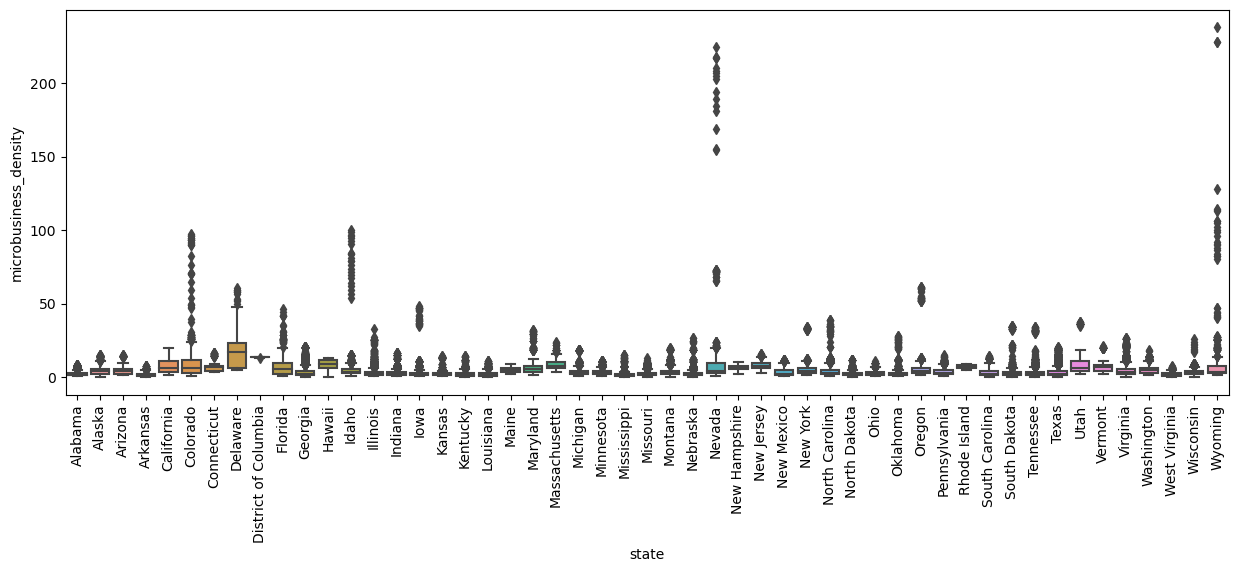

In [242]:
fig, ax = plt.subplots()

sns.boxplot(data = train_df, x='state',y=('microbusiness_density'))

fig.set_size_inches(15,5)
for item in ax.get_xticklabels():
    item.set_rotation(90)

In [243]:
train_df['microbusiness_density'].max()

238.06042

------------------
We check how many lags using ACF and partial ACF plots:

/home/ncozzi/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/ncozzi/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


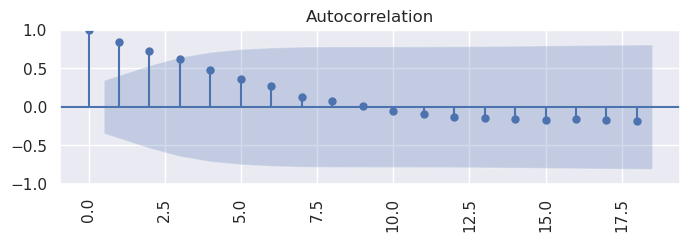

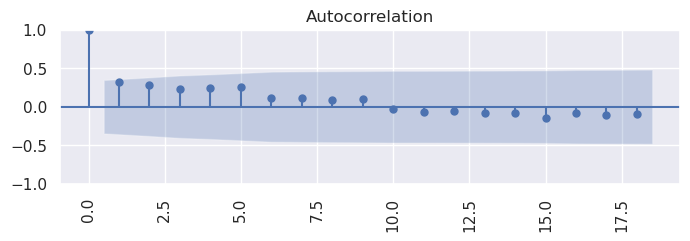

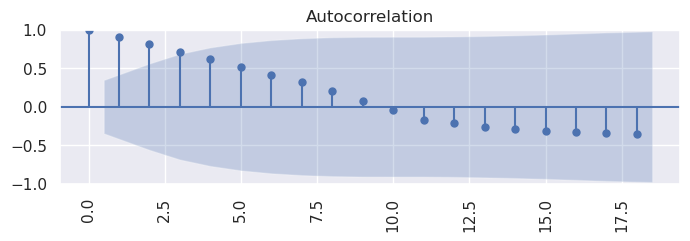

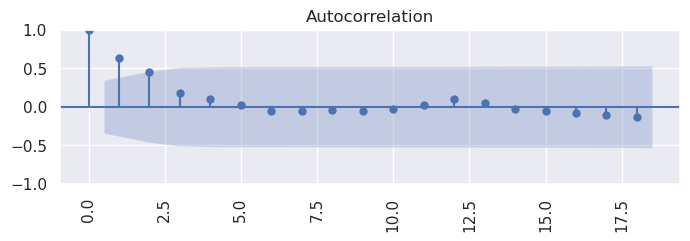

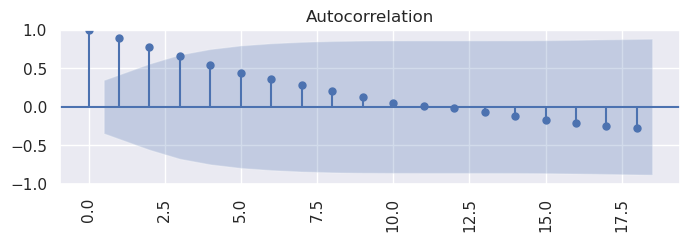

In [244]:
import random
sample_cfips = random.sample(train_df.cfips.unique().tolist(), 5)

for cfips in sample_cfips:
    sns.set()
    fig, ax = plt.subplots()
    plot_acf(train_df[train_df.cfips==cfips]['microbusiness_density'], ax=ax, lags=18)
    fig.set_size_inches(8,2)
    for item in ax.get_xticklabels():
        item.set_rotation(90)

/home/ncozzi/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


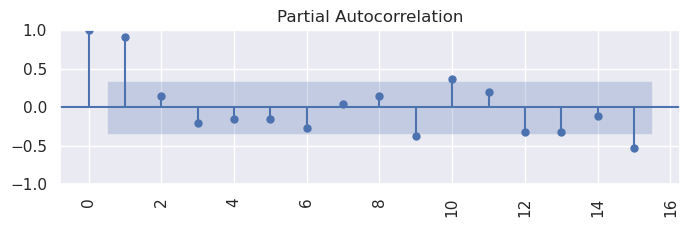

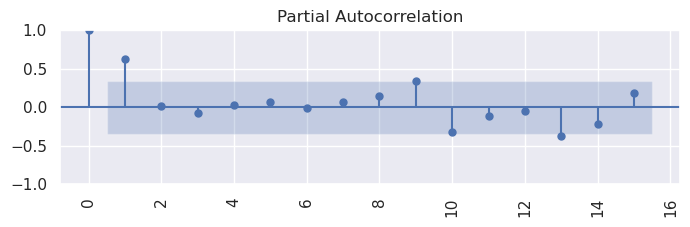

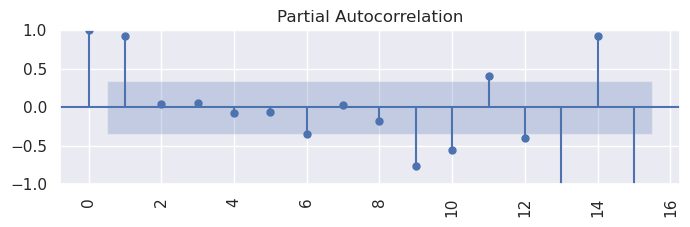

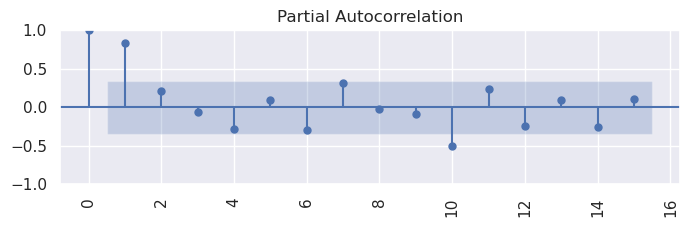

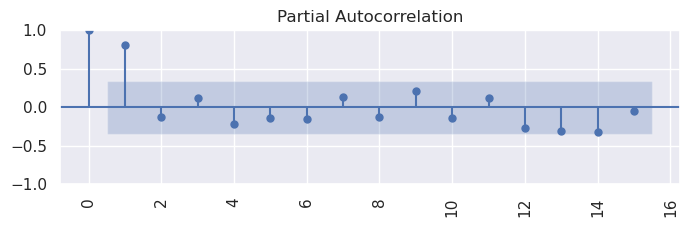

In [245]:
import random
sample_cfips = random.sample(train_df.cfips.unique().tolist(), 5)

for cfips in sample_cfips:
    sns.set()
    fig, ax = plt.subplots()
    plot_pacf(train_df[train_df.cfips==cfips]['microbusiness_density'], ax=ax, lags=15)
    fig.set_size_inches(8,2)
    for item in ax.get_xticklabels():
        item.set_rotation(90)

In [246]:
from scipy import signal
import random
sample_cfips = random.sample(train_df.cfips.unique().tolist(), 5)

def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

def ccf_plot(lags, ccf, title):
    fig, ax =plt.subplots(figsize=(12, 2))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, 
    linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, 
    linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title(title, weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()


#ccf_vals = ccf_values(train_df[train_df.cfips==1001]['log_mbd'], train_df[train_df.cfips==1001]['active'])
#lags = signal.correlation_lags(len(train_df[train_df.cfips==1001]['log_mbd']), len(train_df[train_df.cfips==1001]['active']))

#ccf_plot(lags, ccf_vals)

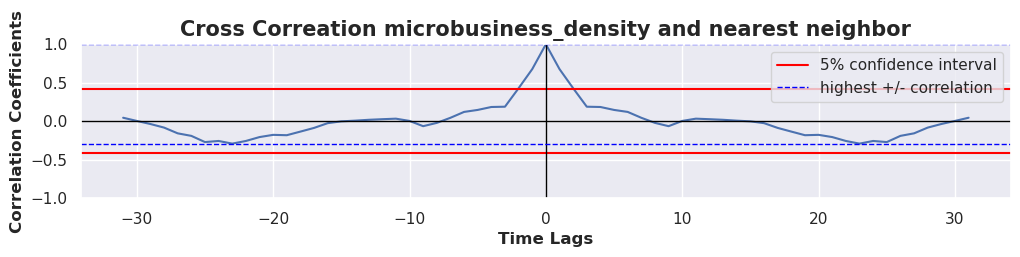

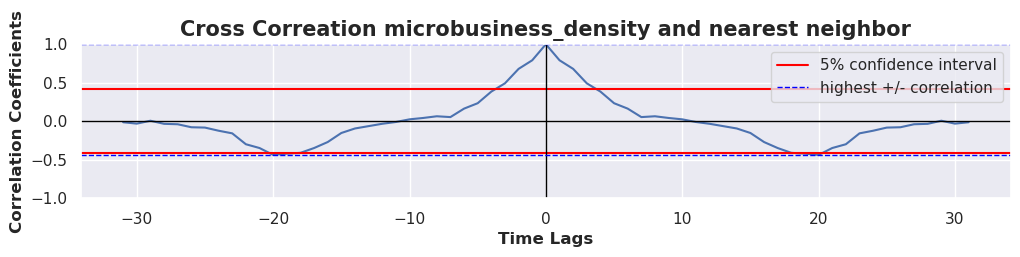

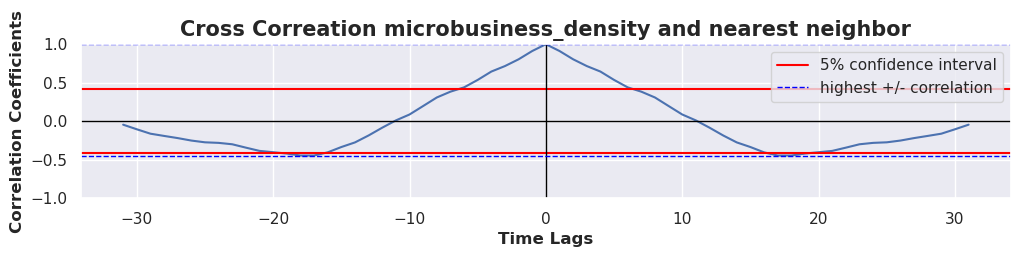

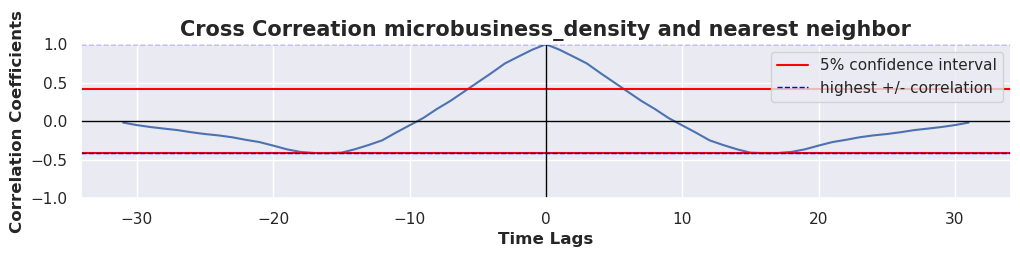

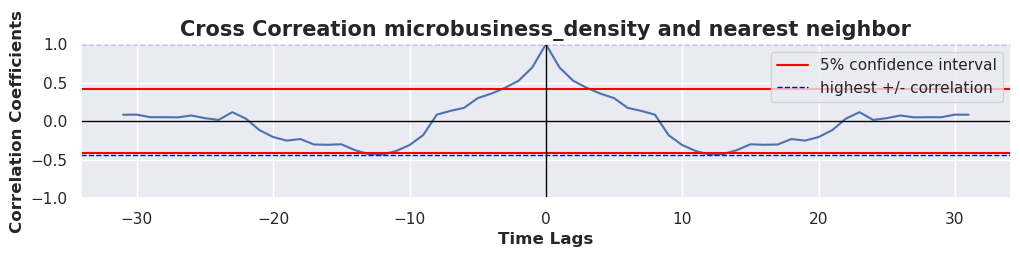

In [247]:
import random
sample_cfips = random.sample(train_df.cfips.unique().tolist(), 5)

for cfips in sample_cfips:
    ccf_vals = ccf_values(train_df[train_df.cfips==cfips]['microbusiness_density'], train_df[train_df.cfips==cfips]['mbd_nearest_1'])
    lags = signal.correlation_lags(len(train_df[train_df.cfips==cfips]['microbusiness_density']), len(train_df[train_df.cfips==cfips]['mbd_nearest_1']))
    sns.set()
    #fig, ax = plt.subplots()
    ccf_plot(lags, ccf_vals, title='Cross Correation microbusiness_density and nearest neighbor')
    fig.set_size_inches(8,2)
    for item in ax.get_xticklabels():
        item.set_rotation(90) 

/home/ncozzi/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/ncozzi/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/ncozzi/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/ncozzi/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/ncozzi/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.versi

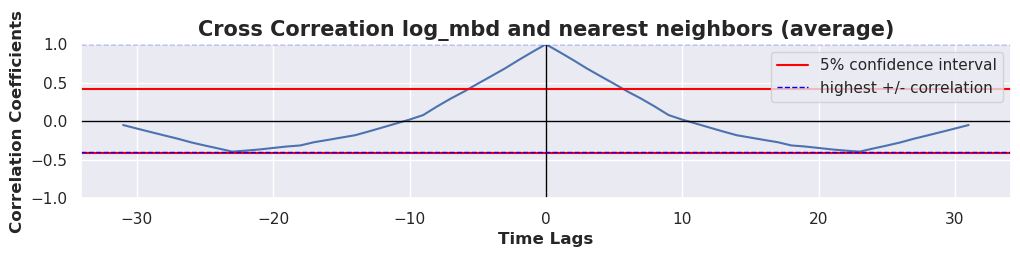

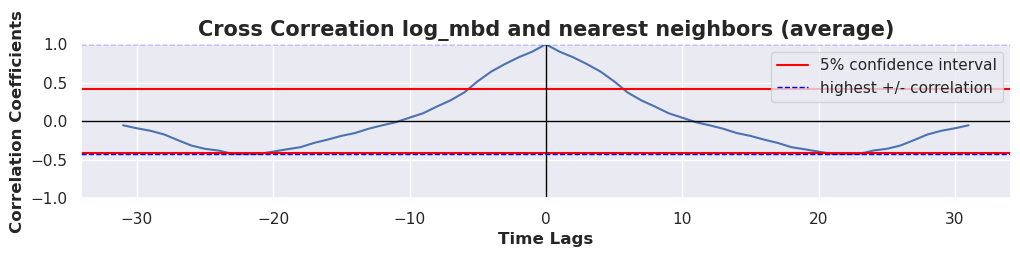

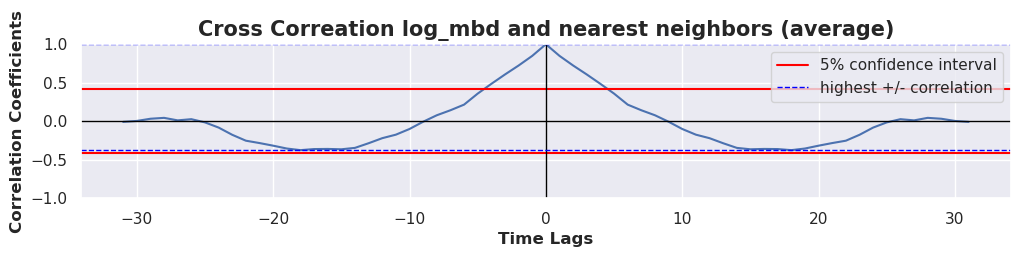

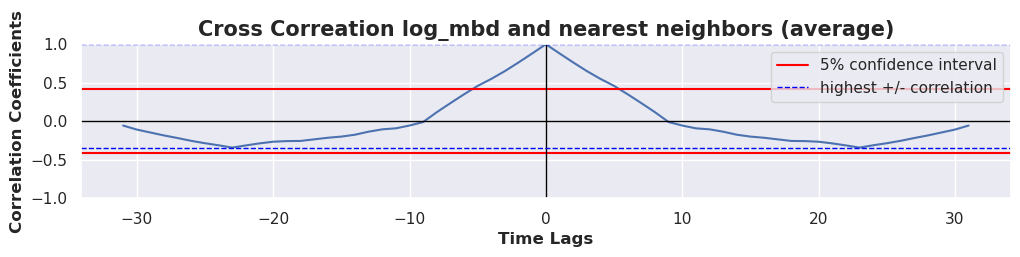

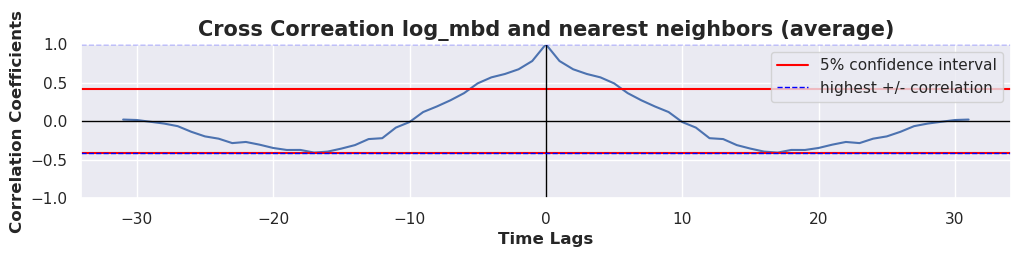

In [248]:
import random
sample_cfips = random.sample(train_df.cfips.unique().tolist(), 5)

for cfips in sample_cfips:
    ccf_vals = ccf_values(train_df[train_df.cfips==cfips]['microbusiness_density'],
                          train_df[train_df.cfips==cfips][[f'mbd_nearest_{i}' for i in range(1,max_neighbors+1)]].mean(axis=1))
    lags = signal.correlation_lags(len(train_df[train_df.cfips==cfips]['microbusiness_density']), len(train_df[train_df.cfips==cfips]['mbd_nearest_1']))
    sns.set()
    #fig, ax = plt.subplots()
    ccf_plot(lags, ccf_vals, title='Cross Correation log_mbd and nearest neighbors (average)')
    fig.set_size_inches(8,2)
    for item in ax.get_xticklabels():
        item.set_rotation(90) 

#### Adding lagged values

In [346]:
train_df = train_df_backup.copy()
test_df = test_df_backup.copy()

In [347]:
def shift_time(df, n):
    return pd.DataFrame(np.array([df.groupby('cfips')[col].shift(n) for col in df.columns]).transpose(),
                                  columns = df.columns)



def gwt_m(dataframe, variable, lag=0):
    def divide_if_zero(a,b):
        try:
            return a/b-1
        except ZeroDivisionError:
            return 0

    vect_div = np.vectorize(divide_if_zero)
    return vect_div(shift_time(dataframe, lag)[variable], shift_time(dataframe, lag+1)[variable])



def gwt_q(dataframe, variable, lag=0):
    def divide_if_zero(a,b):
        try:
            return a/b-1
        except ZeroDivisionError:
            return 0

    vect_div = np.vectorize(divide_if_zero)
    return vect_div(shift_time(dataframe, lag)[variable], shift_time(dataframe, lag+3)[variable])

In [348]:
train_df['gwt_m'] = gwt_m(train_df, 'microbusiness_density', lag=0)
train_df['gwt_q'] = gwt_q(train_df, 'microbusiness_density', lag=0)
if np.max(lag_list)>=9:
    train_df['active(t-12)']=shift_time(train_df, 12)['active']
for i in range(1,max_neighbors+1):
    train_df[f'gwt_m_nearest_{i}']=gwt_m(train_df, f'mbd_nearest_{i}', lag=0)
    train_df[f'gwt_q_nearest_{i}']=gwt_q(train_df, f'mbd_nearest_{i}', lag=0)
for lag in lag_list:
    train_df[f'mbd(t-{lag})'] = shift_time(train_df, lag)['microbusiness_density']
    train_df[f'active(t-{lag})'] = shift_time(train_df, lag)['active']
    train_df[f'gwt_m(t-{lag})'] = gwt_m(train_df, 'microbusiness_density', lag=lag)
    train_df[f'gwt_q(t-{lag})'] = gwt_q(train_df, 'microbusiness_density', lag=lag)
    for i in range(1,max_neighbors+1):
        train_df[f'mbd(t-{lag})_nearest_{i}']=shift_time(train_df, lag)[f'mbd_nearest_{i}']
        train_df[f'gwt_m(t-{lag})_nearest_{i}']=gwt_m(train_df, f'mbd_nearest_{i}', lag=lag)
        train_df[f'gwt_q(t-{lag})_nearest_{i}']=gwt_q(train_df, f'mbd_nearest_{i}', lag=lag)

In [349]:
vf_columns = ['avg_traffic', 'gmv_rank', 'merchants_rank', 'orders_rank']
for column in vf_columns:
    train_df['{}(t-12)'.format(column)]=shift_time(train_df, 6)[column]

#### Adding rolling mean (of last month over 5 periods)

In [350]:
train_df.groupby('cfips').apply(
    lambda x: x['microbusiness_density'].shift(1).rolling(5).mean()).reset_index().set_index('level_1').drop('cfips',axis=1)

,microbusiness_density
level_1,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
128530,1.788966
128531,1.792537
128532,1.796108


In [351]:
for lag in lag_rolling_list:
    train_df['mbd_rolling_mean(t-{})'.format(lag)] = train_df.groupby('cfips').apply(
        lambda x: x['microbusiness_density'].shift(lag).rolling(5).mean()).reset_index().set_index('level_1').drop('cfips',axis=1)
    train_df['gwt_m_rolling_mean(t-{})'.format(lag)] = train_df.groupby('cfips').apply(
        lambda x: x['gwt_m'].shift(lag).rolling(5).mean()).reset_index().set_index('level_1').drop('cfips',axis=1)
    train_df['active_rolling_mean(t-{})'.format(lag)] = train_df.groupby('cfips').apply(
        lambda x: x['active'].shift(lag).rolling(5).mean()).reset_index().set_index('level_1').drop('cfips',axis=1)

#### Drop rows with missing values

In [352]:
# drop groups with missing values
column_for_dropping = 'gwt_q(t-{})'.format(np.max(lag_list))
train_df = train_df.loc[train_df.groupby('first_day_of_month')[column_for_dropping].filter(lambda x: len(x[pd.isnull(x)] ) < 1).index]
column_for_dropping = 'gwt_m_rolling_mean(t-{})'.format(np.max(lag_rolling_list))
train_df = train_df.loc[train_df.groupby('first_day_of_month')[column_for_dropping].filter(lambda x: len(x[pd.isnull(x)] ) < 1).index]

In [353]:
train_df.isna().sum()[train_df.isna().sum()>0]

avg_traffic       18810
gmv_rank          18810
merchants_rank    18810
orders_rank       18810
dtype: int64

In [354]:
train_df.shape

(109725, 66)

### Merging dataframes: part 2

In [355]:
if np.max(lag_list)>=9:
    train_date = [x for x in pd.to_datetime(train_df.first_day_of_month)]
    train_df['date_to_drop'] = train_date
    train_df['january'] = np.where(train_df['date_to_drop'].dt.month==1, 1, 0)
    train_df['year_t'] = train_df['date_to_drop'].dt.year
    train_df['month_t'] = train_df['date_to_drop'].dt.month
    train_df['date_match']=train_df['year_t'].astype(str)+'-'+train_df['month_t'].astype(str)+'-'+train_df['cfips'].astype(str)

    test_date = [x for x in pd.to_datetime(test_df.first_day_of_month)]
    test_df['date_to_drop'] = test_date
    test_df['january'] = np.where(test_df['date_to_drop'].dt.month==1, 1, 0)
    test_df['year_t'] = test_df['date_to_drop'].dt.year-1
    test_df['month_t'] = test_df['date_to_drop'].dt.month
    test_df['date_match']=test_df['year_t'].astype(str)+'-'+test_df['month_t'].astype(str)+'-'+test_df['cfips'].astype(str)

    list_to_merge = ['microbusiness_density','active']
    list_to_merge += [f'mbd_nearest_{i}' for i in list(range(1,max_neighbors+1))]
    #list_to_merge += ['log_mbd_nearest_avg']

    test_df = test_df.merge(train_df[list_to_merge+['date_match']], on=['date_match'], how='left').drop_duplicates()

    test_columns = ['row_id', 'cfips', 'first_day_of_month', 'year', 'countyfp', 'fips',
           'lat', 'lon', 'median_hh_inc', 'pct_bb', 'pct_college',
           'pct_foreign_born', 'pct_it_workers', 'county', 'state', 'date_to_drop',
                    'january',
           'year_t', 'month_t', 'date_match', 'mbd(t-12)', 'active(t-12)']
                   #'gwt_m_ly', 'gwt_q_ly']

    test_columns += [f'mbd(t-12)_nearest_{i}' for i in list(range(1,max_neighbors+1))]

    test_df.columns = test_columns

In [356]:
if np.max(lag_list)>=9:
    train_df = train_df.drop(['active','date_to_drop','year_t','date_match'], axis=1)
    test_df = test_df.drop(['date_to_drop','year_t','date_match'], axis=1)

In [357]:
train_df.shape

(109725, 66)

### Saving to DF

In [358]:
train_df.to_csv('data/train_merged3.csv', index=False)
test_df.to_csv('data/test_merged3.csv', index=False)

----------------------------------
## Building prediction models

In [452]:
train_df = pd.read_csv('data/train_merged3.csv')
test_df = pd.read_csv('data/test_merged3.csv')

In [453]:
train_df.isna().sum().sum()

75240

In [454]:
train_df.shape

(109725, 66)

In [455]:
train_df.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'year', 'median_hh_inc', 'pct_bb',
       'pct_college', 'pct_foreign_born', 'pct_it_workers', 'avg_traffic',
       'gmv_rank', 'merchants_rank', 'orders_rank', 'countyfp', 'fips', 'lat',
       'lon', 'mbd_nearest_1', 'mbd_nearest_2', 'gwt_m', 'gwt_q',
       'gwt_m_nearest_1', 'gwt_q_nearest_1', 'gwt_m_nearest_2',
       'gwt_q_nearest_2', 'mbd(t-1)', 'active(t-1)', 'gwt_m(t-1)',
       'gwt_q(t-1)', 'mbd(t-1)_nearest_1', 'gwt_m(t-1)_nearest_1',
       'gwt_q(t-1)_nearest_1', 'mbd(t-1)_nearest_2', 'gwt_m(t-1)_nearest_2',
       'gwt_q(t-1)_nearest_2', 'mbd(t-2)', 'active(t-2)', 'gwt_m(t-2)',
       'gwt_q(t-2)', 'mbd(t-2)_nearest_1', 'gwt_m(t-2)_nearest_1',
       'gwt_q(t-2)_nearest_1', 'mbd(t-2)_nearest_2', 'gwt_m(t-2)_nearest_2',
       'gwt_q(t-2)_nearest_2', 'mbd(t-3)', 'active(t-3)', 'gwt_m(t-3)',
       'gwt_q(t-3)', 'mbd(t-3)_nearest_1', 'gwt_m(t-3)_nearest_1',
      

In [456]:
len(train_df.first_day_of_month.unique())

35

In [457]:
print(train_df.isna().sum().sum())
print(test_df.isna().sum().sum())

75240
0


### Copying df for data scaling later

In [458]:
train_scaled = train_df.copy()
test_scaled = test_df.copy()

In [459]:
if states_dummy:
    train_scaled = pd.get_dummies(train_scaled, columns=['state'])
    test_scaled = pd.get_dummies(test_scaled, columns=['state'])

In [460]:
train_scaled.shape

(109725, 116)

### Fourier seasonality

In [461]:
def fourier_seasonality(data):
    for order in range(1,13):
        month = pd.DatetimeIndex(data.first_day_of_month).month
        data[f'fourier_sin_order_{order}'] = np.sin(2*np.pi*order*month/12)
        data[f'fourier_cos_order_{order}'] = np.cos(2*np.pi*order*month/12)
                         
   # return pd.DataFrame(fourier_features)
    return data

In [462]:
if fourier_set:
    train_scaled = fourier_seasonality(train_scaled)
    test_scaled = fourier_seasonality(test_scaled)

In [463]:
train_scaled = train_scaled.sort_values(['first_day_of_month','cfips'])
test_scaled = test_scaled.sort_values(['first_day_of_month','cfips'])

### Handling outliers: winsorizing by median absolute deviation

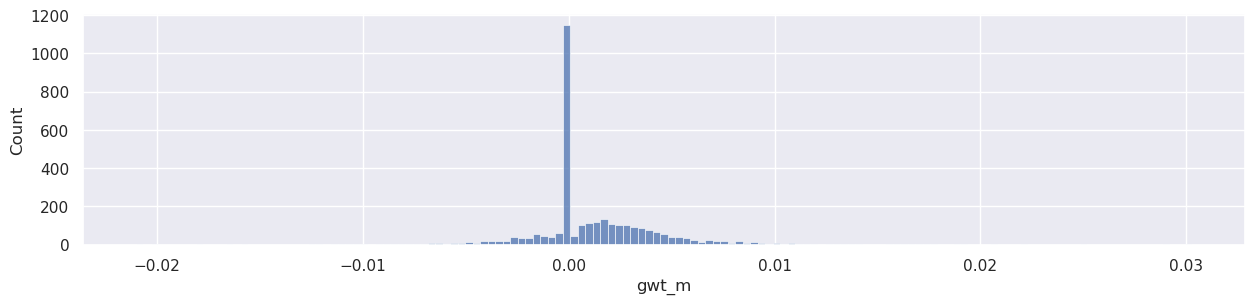

In [464]:
median_mbd_plot = train_scaled.groupby("cfips")['gwt_m'].median()
fig, ax = plt.subplots()
sns.histplot(data = median_mbd_plot)
fig.set_size_inches(15,3)

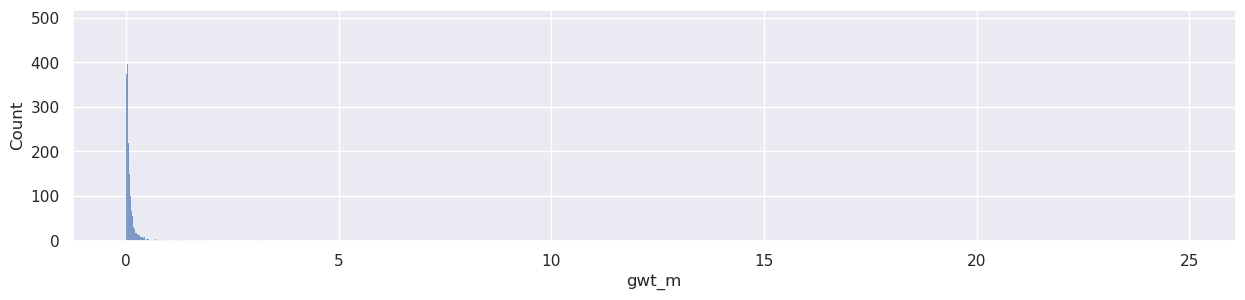

In [465]:
mean_mbd_plot = train_scaled.groupby("cfips")['gwt_m'].max()
fig, ax = plt.subplots()
sns.histplot(data = mean_mbd_plot)
fig.set_size_inches(15,3)

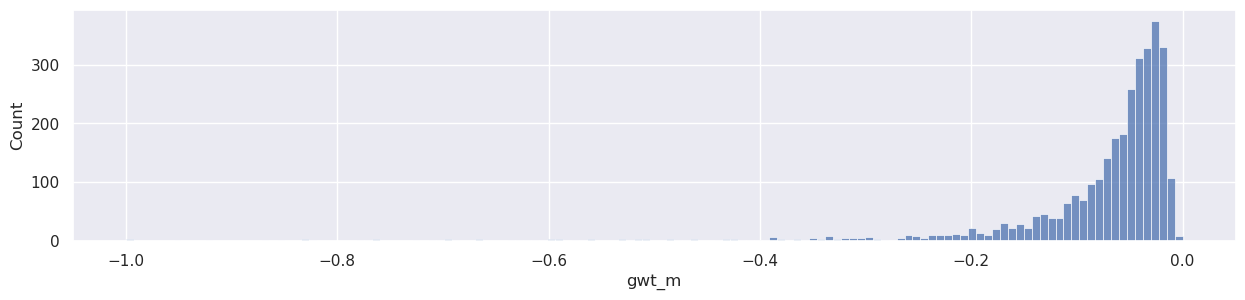

In [466]:
mean_mbd_plot = train_scaled.groupby("cfips")['gwt_m'].min()
fig, ax = plt.subplots()
sns.histplot(data = mean_mbd_plot)
fig.set_size_inches(15,3)

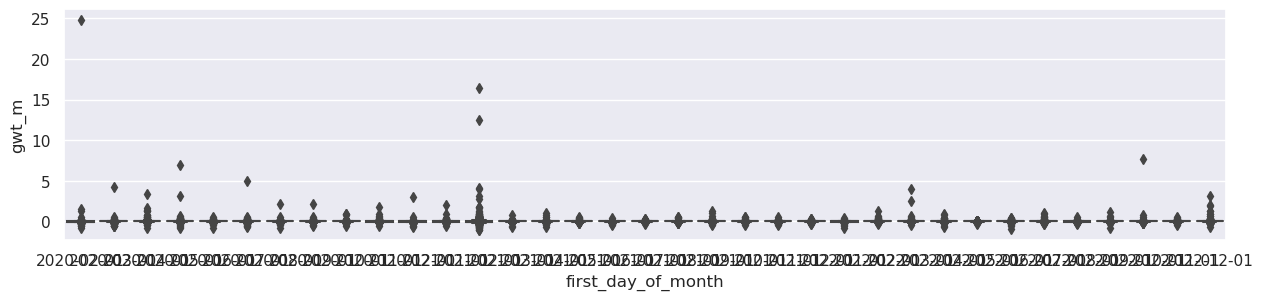

In [467]:
fig, ax = plt.subplots()

sns.boxplot(data = train_scaled, x='first_day_of_month', y='gwt_m')

fig.set_size_inches(15,3)

In [468]:
mad_cutoff = 50

compare_df = pd.DataFrame({'cfips': train_scaled.cfips, 'date': train_scaled.first_day_of_month, 'gwt_m': train_scaled['gwt_m']})
median_gwt = np.median(compare_df['gwt_m'])
MAD = median_abs_deviation(compare_df['gwt_m'])
compare_df['x_minus_median'] = compare_df['gwt_m'] - median_gwt
compare_df['x-m/mad'] = compare_df['x_minus_median']/MAD
compare_df[np.abs(compare_df['x-m/mad'])>mad_cutoff].shape

(214, 5)

In [469]:
mad_cutoff*MAD + median_gwt

0.4082311166621

In [470]:
def replace_outlier_mad(data, variable, mad_cutoff=mad_cutoff):
    compare_df = pd.DataFrame({'cfips': data.cfips, 'date': data.first_day_of_month, variable: data[variable]})
    median = np.median(compare_df[variable])
    MAD = median_abs_deviation(compare_df[variable])
    compare_df['x_minus_median'] = compare_df[variable] - median
    compare_df['x-m/mad'] = compare_df['x_minus_median']/MAD
    replace_max = np.repeat(median + mad_cutoff*MAD, len(compare_df))
    replace_min = np.repeat(median - mad_cutoff*MAD, len(compare_df))
    compare_df[variable] = np.where(compare_df['x-m/mad']>mad_cutoff,
                                   replace_max,
                                   compare_df[variable])
    compare_df[variable] = np.where(compare_df['x-m/mad']<-mad_cutoff,
                                   replace_min,
                                   compare_df[variable])
    # compare_df.loc[compare_df['x-m/mad']>mad_cutoff][variable] = median + mad_cutoff*MAD
    # compare_df.loc[compare_df['x-m/mad']<mad_cutoff][variable] = median - mad_cutoff*MAD
    data[variable] = compare_df[variable]
    return data

# try:
#     pd.options.mode.chained_assignment = None

In [471]:
if winsorize:
    columns_outliers = ['gwt_m', 'gwt_q']
    columns_outliers.extend(['gwt_m_nearest_{}'.format(i) for i in range(1,max_neighbors+1)])
    columns_outliers.extend(['gwt_q_nearest_{}'.format(i) for i in range(1,max_neighbors+1)])
    columns_outliers.extend(['gwt_m(t-{})'.format(i) for i in lag_list])
    columns_outliers.extend(['gwt_q(t-{})'.format(i) for i in lag_list])
    columns_outliers.extend([f'gwt_m(t-{lag})_nearest_{i}' for lag, i in lag_neigh_c])
    columns_outliers.extend([f'gwt_q(t-{lag})_nearest_{i}' for lag, i in lag_neigh_c])
    
    for column in columns_outliers:
        train_scaled = replace_outlier_mad(train_scaled, column)

### Defining train_x, etcetera

In [472]:
cols_to_drop = ['row_id', 'cfips', 'county', 'first_day_of_month', 'microbusiness_density','year',
                'countyfp', 'fips','lat', 'lon', 'gwt_m', 'gwt_q','active']
if not states_dummy:
    cols_to_drop.extend(['state'])

if np.max(lag_list)>=9: cols_to_drop.extend(['month_t'])

# VF columns
vf_columns = ['avg_traffic', 'gmv_rank', 'merchants_rank', 'orders_rank']
cols_to_drop.extend(vf_columns)

# neighbors
cols_to_drop.extend([f'mbd_nearest_{i}' for i in range(1,max_neighbors+1)])
cols_to_drop.extend([f'gwt_m_nearest_{i}' for i in range(1,max_neighbors+1)])
cols_to_drop.extend([f'gwt_q_nearest_{i}' for i in range(1,max_neighbors+1)])

In [473]:
x_columns = train_scaled.drop(cols_to_drop, axis=1).columns

In [474]:
x_columns

Index(['median_hh_inc', 'pct_bb', 'pct_college', 'pct_foreign_born',
       'pct_it_workers', 'mbd(t-1)', 'active(t-1)', 'gwt_m(t-1)', 'gwt_q(t-1)',
       'mbd(t-1)_nearest_1', 'gwt_m(t-1)_nearest_1', 'gwt_q(t-1)_nearest_1',
       'mbd(t-1)_nearest_2', 'gwt_m(t-1)_nearest_2', 'gwt_q(t-1)_nearest_2',
       'mbd(t-2)', 'active(t-2)', 'gwt_m(t-2)', 'gwt_q(t-2)',
       'mbd(t-2)_nearest_1', 'gwt_m(t-2)_nearest_1', 'gwt_q(t-2)_nearest_1',
       'mbd(t-2)_nearest_2', 'gwt_m(t-2)_nearest_2', 'gwt_q(t-2)_nearest_2',
       'mbd(t-3)', 'active(t-3)', 'gwt_m(t-3)', 'gwt_q(t-3)',
       'mbd(t-3)_nearest_1', 'gwt_m(t-3)_nearest_1', 'gwt_q(t-3)_nearest_1',
       'mbd(t-3)_nearest_2', 'gwt_m(t-3)_nearest_2', 'gwt_q(t-3)_nearest_2',
       'avg_traffic(t-12)', 'gmv_rank(t-12)', 'merchants_rank(t-12)',
       'orders_rank(t-12)', 'mbd_rolling_mean(t-1)', 'gwt_m_rolling_mean(t-1)',
       'active_rolling_mean(t-1)', 'state_Alabama', 'state_Alaska',
       'state_Arizona', 'state_Arkansas', 'stat

In [475]:
x_train = train_scaled[x_columns]
y_train = train_scaled['gwt_m']
groups = pd.factorize(train_scaled.first_day_of_month)[0]
# x_train.loc[:,'year_2020'] = np.where(pd.DatetimeIndex(train_scaled_filtered.first_day_of_month).year==2020,1,0)

x_test = test_scaled[list(set(test_scaled.columns) & set(x_columns))]


list_1 = list(train_scaled.columns)
list_2 = list(test_scaled.columns)
columns_to_add = list(set(list_1) - set(list_2))

In [476]:
x_columns = x_train.columns

In [477]:
x_train.isna().sum().sum()

0

In [478]:
x_train.shape

(109725, 93)

In [479]:
x_test.shape

(18810, 56)

In [480]:
# x_scaler = StandardScaler()
x_scaler = QuantileTransformer(n_quantiles=15000)
x_scaler.fit(x_train)
x_train = pd.DataFrame(x_scaler.transform(x_train), columns = x_train.columns)

In [481]:
y_scaler = QuantileTransformer(n_quantiles=10000)
y_scaler.fit(y_train.values.reshape(-1, 1))
y_train = pd.Series(list(itertools.chain(*y_scaler.transform(y_train.values.reshape(-1, 1)))), name=y_train.name, index=y_train.index)

### Set CV method

#### Time series CV
http://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/

In [548]:
tscv_args = {"test_size": 3, "n_splits": 12, 'gap_size': 2}
groups = pd.factorize(train_scaled.first_day_of_month)[0]
cv = GroupTimeSeriesSplit(**tscv_args)

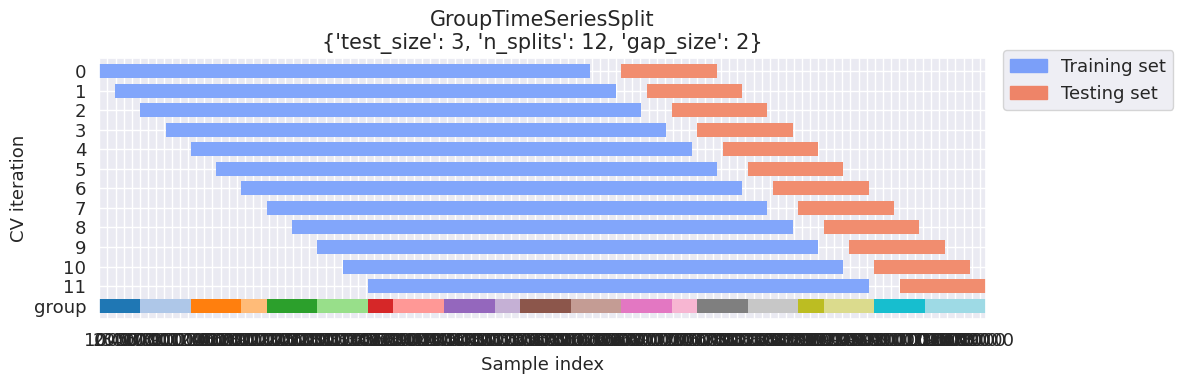

In [549]:
plot_splits(x_train, y_train, groups, **tscv_args)

### Defining loss function:

In [484]:
def huber_loss(actual, forecast):
    delta=0.05
    d = actual-forecast
    loss_array = np.where(np.abs(actual-forecast)<=delta, 0.5*d**2, delta*(np.abs(d)-delta/2))
    return -loss_array.mean()

huber_loss_score = make_scorer(huber_loss, greater_is_better=True)

### Trying algorithms:

#### Linear SVR

In [550]:
svr_regressor = LinearSVR(dual=False, loss='squared_epsilon_insensitive')
svr_regressor.fit(x_train, y_train.values)
model = svr_regressor
best_cv_score = cross_val_score(svr_regressor, x_train, y_train.values, groups=groups, cv=cv, scoring=huber_loss_score).mean()
print(best_cv_score)
# -0.24157922858641806
# -0.24147544454483955
# -0.010871916252180583
# -0.010621981110593306

-0.010763728548123975


In [ ]:
# Bayesian optimization

pbounds = {
    'tol':(-6,0),
    'C': (-6,0),
    'epsilon': (0,10)
}

def svr_hyper_param(
    tol,
    C,
    epsilon):

    reg = LinearSVR(dual=False, loss='squared_epsilon_insensitive',
                    tol=pow(10,tol),
                    C=pow(10,C),
                    epsilon=epsilon
                   )
    
    return np.mean(cross_val_score(reg, x_train.values, y_train.values, cv=cv, groups=groups, scoring=huber_loss_score))

svr_optimizer = BayesianOptimization(
    f=svr_hyper_param,
    pbounds=pbounds,
    verbose=1,
    random_state=777,
)

svr_optimizer.maximize(init_points=15, n_iter=200)
# -0.2386

|   iter    |  target   |     C     |  epsilon  |    tol    |
-------------------------------------------------------------
| 4         | -0.02054  | -2.136    | 0.9337    | -5.522    |
| 16        | -0.01076  | -0.9694   | 0.0       | -5.903    |
| 19        | -0.01073  | 0.0       | 0.0       | -1.976    |
| 27        | -0.01073  | -2.503    | 0.0       | -2.062    |
| 30        | -0.0107   | -3.693    | 0.0       | -3.595    |
| 32        | -0.01069  | -3.565    | 0.0       | -2.759    |
| 40        | -0.01068  | -3.416    | 0.01895   | -5.42     |


In [487]:
if svr_optimizer.max['target'] > best_cv_score:
    svr_regressor = LinearSVR(dual=False, loss='squared_epsilon_insensitive')
    svr_regressor.set_params(
        tol=pow(10, svr_optimizer.max['params']['tol']),
        C=pow(10, svr_optimizer.max['params']['C'])
        )
    svr_regressor.fit(x_train, y_train.values)
    model = svr_regressor
    best_cv_score = svr_optimizer.max['target']

In [488]:
perm_importance_svr = permutation_importance(svr_regressor, x_train, y_train)

feature_names_svr = x_train.columns
features_svr = np.array(feature_names_svr)

sorted_idx_svr = perm_importance_svr.importances_mean.argsort()

Text(0.5, 0, 'Permutation Importance')

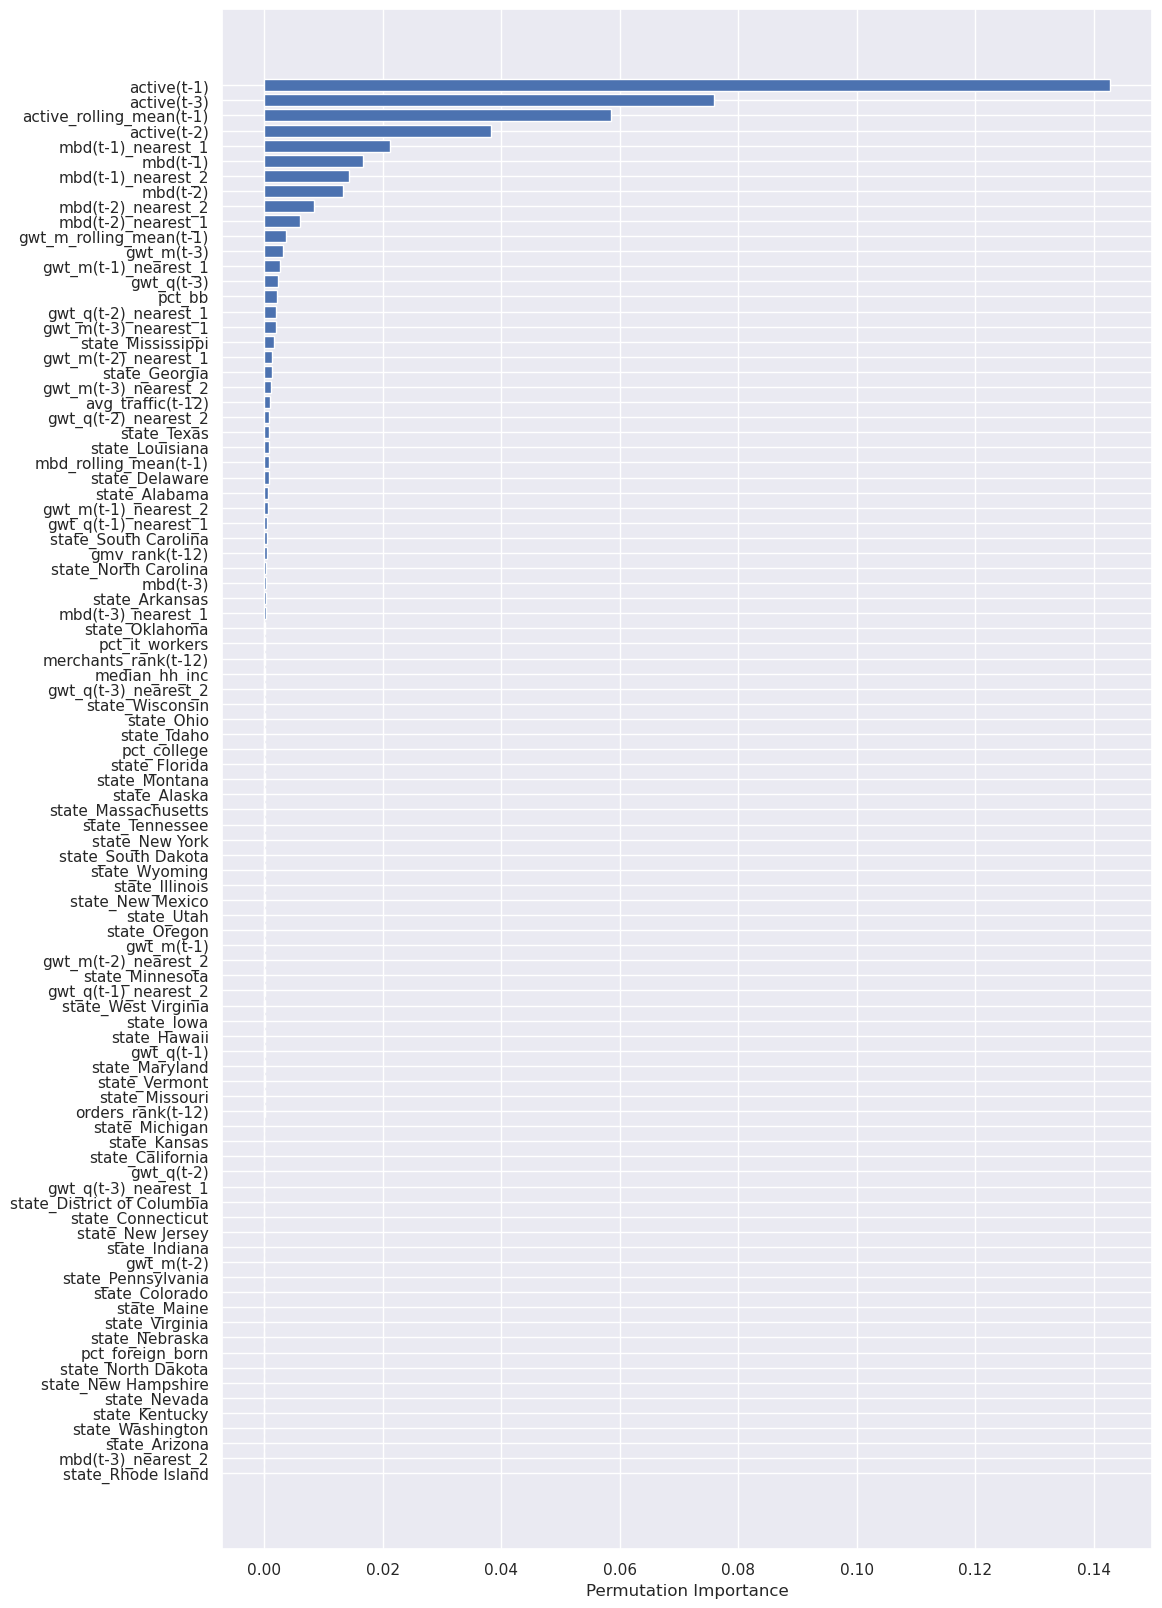

In [489]:
plt.rcParams['figure.figsize'] = [12, 20]
plt.barh(features_svr[sorted_idx_svr], perm_importance_svr.importances_mean[sorted_idx_svr])
plt.xlabel("Permutation Importance")

#### Light GBM

In [397]:
lgbm = LGBMRegressor(boosting_type='goss', num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=500, subsample_for_bin=50000,
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0,
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=777, n_jobs=None,
                     importance_type='split')
lgbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='goss', n_estimators=500, n_jobs=None,
              random_state=777, subsample_for_bin=50000)

In [398]:
cv_score_lgb = cross_val_score(lgbm, x_train, y_train.values, cv=cv, groups=groups, scoring=huber_loss_score).mean()
print(cv_score_lgb)
if cv_score_lgb>best_cv_score:
    model = lgbm
    best_cv_score = cv_score_lgb

-0.01094260341872323


In [532]:
# Bayesian optimization

pbounds = {
    'num_leaves':(10,50),
    'learning_rate': (-3,0),
    'n_estimators': (100, 2500),
    'subsample_for_bin': (10000, 200000),
    'min_child_samples': (10,30),
    'subsample': (0.5,1.0),
    'colsample_bytree': (0.5,1),
    'reg_lambda': (0,3),
    'reg_alpha': (0,3)}

def lgb_hyper_param(
    num_leaves,
    learning_rate,
    n_estimators,
    subsample_for_bin,
    min_child_samples,
    subsample,
    colsample_bytree,
    reg_lambda,
    reg_alpha):

    num_leaves = int(num_leaves)
    n_estimators = int(n_estimators)
    subsample_for_bin = int(subsample_for_bin)
    min_child_samples = int(min_child_samples)

    clf = LGBMRegressor(
        boosting_type='goss', num_leaves=num_leaves, max_depth=- 1, learning_rate=pow(10,learning_rate), n_estimators=n_estimators,
        subsample_for_bin=subsample_for_bin,
        objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=min_child_samples,
        subsample=subsample,
        subsample_freq=0, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=777, n_jobs=None,
        importance_type='split'
    )
    
    return np.mean(cross_val_score(clf, x_train.values, y_train.values, cv=cv, groups=groups, scoring=huber_loss_score))

lgb_optimizer = BayesianOptimization(
    f=lgb_hyper_param,
    pbounds=pbounds,
    verbose=2,
    random_state=777,
)

lgb_optimizer.maximize(init_points=15, n_iter=50)

|   iter    |  target   | colsam... | learni... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.2437   | 0.5763    | -2.093    | 11.24     | 1.204e+03 | 43.41     | 2.781     | 2.181     | 0.8842    | 6.115e+04 |
| 2         | -0.2427   | 0.822     | -2.72     | 11.59     | 1.515e+03 | 23.73     | 2.967     | 1.879     | 0.8409    | 1.149e+05 |
| 3         | -0.2432   | 0.6344    | -1.88     | 14.46     | 547.5     | 25.63     | 0.5795    | 1.833     | 0.9414    | 1.282e+05 |
| 4         | -0.2425   | 0.6266    | -2.46     | 26.33     | 640.9     | 30.67     | 1.555     | 1.801     | 0.7663    | 1.253e+04 |
| 5         | -0.2812   | 0.762     | -0.3123   | 25.4      | 394.8     | 21.83     | 1.836     | 2.178     | 0.7317    | 1.561e+05 |
| 6         | -0.2478   | 0.5958    | -1.326    | 21.02     | 

In [533]:
lgb_optimizer_max = lgb_optimizer.max

In [534]:
import pickle 

with open('data/saved_lgbmax.pkl', 'wb') as f:
    pickle.dump(lgb_optimizer_max, f)

In [46]:
import pickle 
with open('data/saved_lgbmax.pkl', 'rb') as f:
    lgb_optimizer_max = pickle.load(f)

In [47]:
if lgb_optimizer_max['target'] > best_cv_score:
    lgbm = LGBMRegressor(boosting_type='goss', random_state = 777)
    lgbm.set_params(
        num_leaves=round(lgb_optimizer_max['params']['num_leaves']),
        learning_rate=pow(10, lgb_optimizer_max['params']['learning_rate']),
        n_estimators=round(lgb_optimizer_max['params']['n_estimators']),
        subsample_for_bin=round(lgb_optimizer_max['params']['subsample_for_bin']),
        min_child_samples=round(lgb_optimizer_max['params']['min_child_samples']),
        subsample=lgb_optimizer_max['params']['subsample'],
        colsample_bytree=lgb_optimizer_max['params']['colsample_bytree'],
        reg_lambda=lgb_optimizer_max['params']['reg_lambda'],
        reg_alpha=lgb_optimizer_max['params']['reg_alpha'],
        )
    lgbm.fit(x_train, y_train)
    model = lgbm
    cv_score_lgb = lgb_optimizer_max['target']

NameError: name 'best_cv_score' is not defined

In [62]:
perm_importance_lgb = permutation_importance(lgbm, x_train, y_train)

feature_names_lgb = x_train.columns
features_lgb = np.array(feature_names_lgb)

sorted_idx_lgb = perm_importance_lgb.importances_mean.argsort()

Text(0.5, 0, 'Permutation Importance')

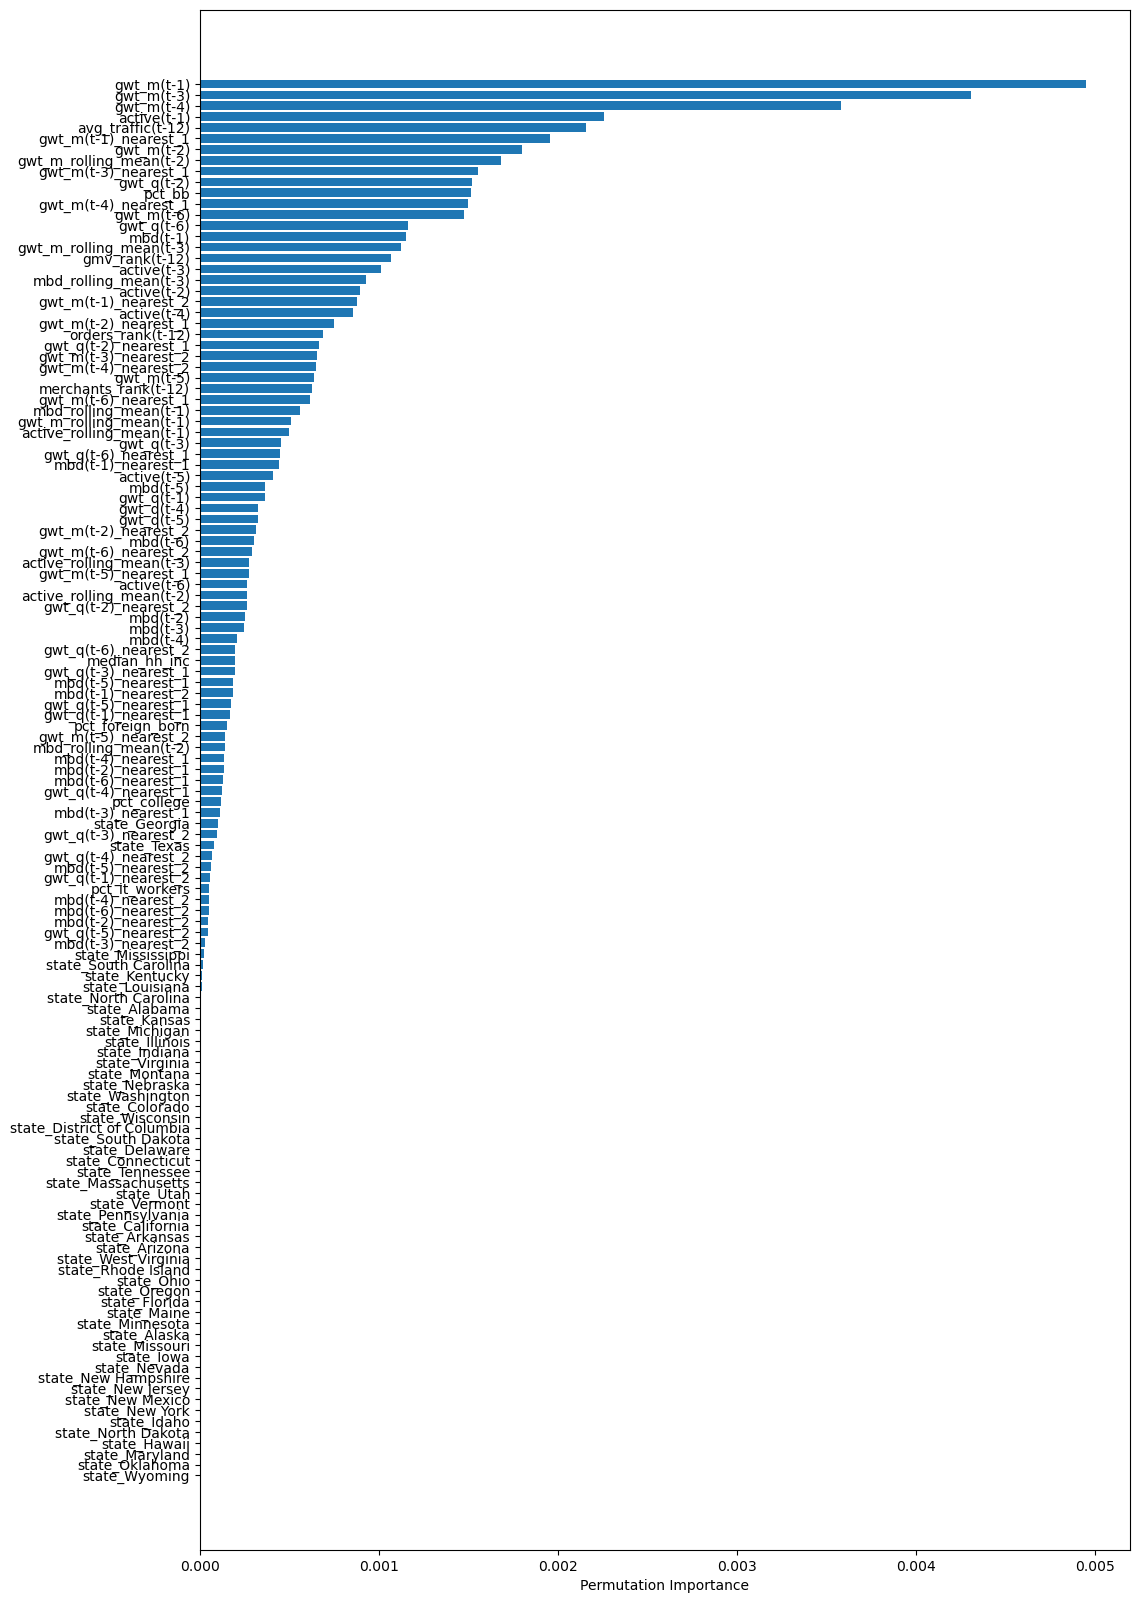

In [63]:
plt.rcParams['figure.figsize'] = [12, 20]
plt.barh(features_lgb[sorted_idx_lgb], perm_importance_lgb.importances_mean[sorted_idx_lgb])
plt.xlabel("Permutation Importance")

In [48]:
lgbm = LGBMRegressor(boosting_type='goss', random_state = 777)
lgbm.set_params(
    num_leaves=round(lgb_optimizer_max['params']['num_leaves']),
    learning_rate=pow(10, lgb_optimizer_max['params']['learning_rate']),
    n_estimators=round(lgb_optimizer_max['params']['n_estimators']),
    subsample_for_bin=round(lgb_optimizer_max['params']['subsample_for_bin']),
    min_child_samples=round(lgb_optimizer_max['params']['min_child_samples']),
    subsample=lgb_optimizer_max['params']['subsample'],
    colsample_bytree=lgb_optimizer_max['params']['colsample_bytree'],
    reg_lambda=lgb_optimizer_max['params']['reg_lambda'],
    reg_alpha=lgb_optimizer_max['params']['reg_alpha'],
    )
lgbm.fit(x_train, y_train)
model = lgbm
cv_score_lgb = lgb_optimizer_max['target']

In [ ]:
lgb.cv(param, nfold=4, train_set=x_train)

#### Catboost

In [506]:
catboost = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2,
                             loss_function='RMSE',
                            verbose=0)
# Fit model
catboost.fit(x_train, y_train)

In [508]:
cv_score_cat = cross_val_score(catboost, x_train, y_train.values, cv=cv, groups=groups, scoring=huber_loss_score).mean()
print(cv_score_cat)
if cv_score_cat>best_cv_score:
    model = catboost
    best_cv_score = cv_score_cat

-0.010694177368706015


In [ ]:
# Bayesian optimization

pbounds = {
    'depth': (2,10),
    'learning_rate': (-4,0),
    'iterations': (10, 2500),
    'random_strength': (-9, 1),
    'bagging_temperature': (0.0, 1.0),
    'l2_leaf_reg': (0., 30.)}

def cat_hyper_param(depth,
    learning_rate,
    iterations,
    random_strength,
    bagging_temperature,
    l2_leaf_reg):

    depth = int(depth)
    iterations = int(iterations)

    catboost = CatBoostRegressor(depth=depth,
                            learning_rate=pow(10,learning_rate),
                            iterations=iterations,
                            random_strength=pow(10,random_strength),
                            bagging_temperature=bagging_temperature,
                            l2_leaf_reg=l2_leaf_reg,
                             loss_function='RMSE',
                             verbose=0)
    
    return np.mean(cross_val_score(catboost, x_train.values, y_train.values, cv=cv, groups=groups, scoring=huber_loss_score))

cat_optimizer = BayesianOptimization(
                f=cat_hyper_param,
                pbounds=pbounds,
                verbose=2,
                random_state=777,
            )

cat_optimizer.maximize(init_points=15, n_iter=50)

#### Neural networks

In [513]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.layers import Dense, Dropout, LSTM, LeakyReLU, BatchNormalization
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
import tensorflow as tf
from tensorflow.keras.utils import plot_model
# tf.compat.v1.disable_eager_execution()

2023-02-28 19:12:46.882550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 19:12:47.539775: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-28 19:12:47.539801: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-28 19:12:51.975720: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [535]:
hidden_units1 = 100
# hidden_units2 = 50
learning_rate = 0.0001
# Creating model using the Sequential in tensorflow
def build_model_using_sequential1():
    model = Sequential([
        Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
        Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
        Dense(1, kernel_initializer='normal')
    ])
    mse = MeanSquaredError()
    model.compile(loss=mse, optimizer=Adam(learning_rate=learning_rate), metrics=[mse])
    return model

In [536]:
es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=0, patience=20)
ann_model1 = KerasRegressor(build_fn=build_model_using_sequential1, epochs=50, batch_size=32, verbose=0)
ann_model1.fit(np.asarray(x_train), np.asarray(y_train), verbose=1, callbacks=[es])

Epoch 1/50


/tmp/ipykernel_5499/1275214622.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann_model1 = KerasRegressor(build_fn=build_model_using_sequential1, epochs=50, batch_size=32, verbose=0)


3429/3429 [==============================] - 9s 2ms/step - loss: 0.0888 - mean_squared_error: 0.0888
Epoch 2/50
3429/3429 [==============================] - 7s 2ms/step - loss: 0.0825 - mean_squared_error: 0.0825
Epoch 3/50
3429/3429 [==============================] - 8s 2ms/step - loss: 0.0821 - mean_squared_error: 0.0821
Epoch 4/50
3429/3429 [==============================] - 8s 2ms/step - loss: 0.0818 - mean_squared_error: 0.0818
Epoch 5/50
3429/3429 [==============================] - 8s 2ms/step - loss: 0.0815 - mean_squared_error: 0.0815
Epoch 6/50
3429/3429 [==============================] - 8s 2ms/step - loss: 0.0813 - mean_squared_error: 0.0813
Epoch 7/50
3429/3429 [==============================] - 7s 2ms/step - loss: 0.0811 - mean_squared_error: 0.0811
Epoch 8/50
3429/3429 [==============================] - 7s 2ms/step - loss: 0.0809 - mean_squared_error: 0.0809
Epoch 9/50
3429/3429 [==============================] - 8s 2ms/step - loss: 0.0807 - mean_squared_error: 0.0807
Epo

In [537]:
cross_val_score(ann_model1, x_train.values, y_train.values, groups=groups, cv=cv, scoring=huber_loss_score).mean()

/home/ncozzi/anaconda3/lib/python3.9/site-packages/sklearn/base.py:87: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  new_object = klass(**new_object_params)
/home/ncozzi/anaconda3/lib/python3.9/site-packages/sklearn/base.py:87: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  new_object = klass(**new_object_params)
/home/ncozzi/anaconda3/lib/python3.9/site-packages/sklearn/base.py:87: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  new_object = klass(**new_object_params)
/home/ncozzi/anaconda3/lib/python3.9/site-packages/sklearn/base.py:87: DeprecationWar

-0.010841373927339332

In [538]:
model = ann_model1

#### LSTM

## Forecasting final resutls

### Adjusting for census 2020 and 2021

In [539]:
COLS = ['GEO_ID','NAME','S0101_C01_026E']
df2020 = pd.read_csv('data/census_godaddy/ACSST5Y2020.S0101-Data.csv',usecols=COLS)
df2020 = df2020.iloc[1:]
df2020['S0101_C01_026E'] = df2020['S0101_C01_026E'].astype('int')
print( df2020.shape )

(3221, 3)


/tmp/ipykernel_5499/2537109819.py:2: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2020 = pd.read_csv('data/census_godaddy/ACSST5Y2020.S0101-Data.csv',usecols=COLS)


In [540]:
df2021 = pd.read_csv('data/census_godaddy/ACSST5Y2021.S0101-Data.csv',usecols=COLS)
df2021 = df2021.iloc[1:]
df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
print( df2021.shape )

(3221, 3)


/tmp/ipykernel_5499/1517537638.py:1: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv('data/census_godaddy/ACSST5Y2021.S0101-Data.csv',usecols=COLS)


In [541]:
df2020['cfips'] = df2020.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2020 = df2020.set_index('cfips').S0101_C01_026E.to_dict()

df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

### Generating predictions

In [542]:
revealed_test_df = pd.read_csv('data/revealed_test.csv')

agg = pd.read_csv('data/5_nearest.csv')
agg.index = agg.cfips

In [543]:
def shift_time(df, n):
    return pd.DataFrame(np.array([df.groupby('cfips')[col].shift(n) for col in df.columns]).transpose(),
                                  columns = df.columns)



def gwt_m(dataframe, variable, lag=0):
    def divide_if_zero(a,b):
        try:
            return a/b-1
        except ZeroDivisionError:
            return 0

    vect_div = np.vectorize(divide_if_zero)
    return vect_div(shift_time(dataframe, lag)[variable], shift_time(dataframe, lag+1)[variable])



def gwt_q(dataframe, variable, lag=0):
    def divide_if_zero(a,b):
        try:
            return a/b-1
        except ZeroDivisionError:
            return 0

    vect_div = np.vectorize(divide_if_zero)
    return vect_div(shift_time(dataframe, lag)[variable], shift_time(dataframe, lag+3)[variable])

In [544]:
test_scaled_copy = test_scaled.copy()
test_scaled_copy = test_scaled_copy.sort_values(['first_day_of_month', 'cfips'])

test_scaled_copy = test_scaled_copy.drop([x for x in test_scaled_copy.columns if not x in train_scaled.columns], axis=1)
target = 'gwt_m'

for column in columns_to_add:
    test_scaled_copy[column] = np.repeat(np.nan, len(test_scaled_copy))

train_test_merge = pd.concat([train_scaled, test_scaled_copy], ignore_index=True)
train_test_merge['first_day_of_month'] = pd.to_datetime(train_test_merge.first_day_of_month)

In [545]:
# settings for the forecast below
adjustment=True

In [546]:
# function for rolling mean
def rolling_mean_df(data, column_to_replace, column_rolled):
    _rolling_mean = data.groupby('cfips', observed=True).apply(
                                            lambda x: x[column_rolled].shift(1).rolling(5).mean()
                                                        ).reset_index().reset_index().set_index('level_1').sort_index()[column_rolled]
    column_return = np.where(data['first_day_of_month']==date,
                             _rolling_mean,
                             data[column_to_replace])
    return column_return

In [547]:
train_test_merge['adult2020'] = train_test_merge.cfips.map(adult2020)
train_test_merge['adult2021'] = train_test_merge.cfips.map(adult2021)
_iteration = 1
n_iterations = len(test_scaled.first_day_of_month.unique())
for date in test_scaled.first_day_of_month.unique():
    
    print('Date of iteration: '+ str(date) + str(' --- ' + str(_iteration)+'/'+str(n_iterations)), end = "\r")
    _iteration+=1
    
    ##########
    # not-neighbor lagged
    train_test_merge[['mbd(t-{})'.format(f) for f in lag_list]] = [*zip(
        *[np.where(train_test_merge.first_day_of_month==date,
                                                    shift_time(train_test_merge, lag)['microbusiness_density'].astype('float32'),
                                                    train_test_merge[f'mbd(t-{lag})'])
         for lag in lag_list]
    )]
    train_test_merge[['active(t-{})'.format(f) for f in lag_list]] = [*zip(
        *[np.where(train_test_merge.first_day_of_month==date,
                                                    shift_time(train_test_merge, lag)['active'].astype('float32'),
                                                    train_test_merge[f'active(t-{lag})'])
         for lag in lag_list]
    )]
    train_test_merge[['gwt_m(t-{})'.format(f) for f in lag_list]] = [*zip(
        *[np.where(train_test_merge.first_day_of_month==date,
                                                    shift_time(train_test_merge, lag)['gwt_m'].astype('float32'),
                                                    train_test_merge['gwt_m(t-{})'.format(lag)])
         for lag in lag_list
        ]
    )]
    train_test_merge[['gwt_q(t-{})'.format(f) for f in lag_list]] = [*zip(
        *[np.where(train_test_merge.first_day_of_month==date,
                                                    shift_time(train_test_merge, lag)['gwt_q'].astype('float32'),
                                                    train_test_merge['gwt_q(t-{})'.format(lag)])
         for lag in lag_list
        ]
    )]
    
    ############
    # VF data
    train_test_merge[['{}(t-12)'.format(col) for col in vf_columns]] = [*zip(
        *[np.where(train_test_merge.first_day_of_month==date,
                                                    shift_time(train_test_merge, 12)[col].astype('float32'),
                                                    train_test_merge['{}(t-12)'.format(col)])
         for col in vf_columns]
    )]
    
    
    ############
    # neighbors
    train_test_merge[[f'mbd(t-{lag})_nearest_{i}' for lag, i in lag_neigh_c]] = [*zip(
        *[np.where(
                train_test_merge.first_day_of_month==date,
                shift_time(train_test_merge, lag)[f'mbd_nearest_{i}'].astype('float32'),
                train_test_merge[f'mbd(t-{lag})_nearest_{i}'])
         for lag, i in lag_neigh_c
        ]
    )]
    train_test_merge[[f'gwt_m(t-{lag})_nearest_{i}' for lag, i in lag_neigh_c]] = [*zip(
        *[np.where(
                train_test_merge.first_day_of_month==date,
                shift_time(train_test_merge, lag)[f'gwt_m_nearest_{i}'].astype('float32'),
                train_test_merge[f'gwt_m(t-{lag})_nearest_{i}'])
         for lag, i in lag_neigh_c
        ]
    )]
    train_test_merge[[f'gwt_q(t-{lag})_nearest_{i}' for lag, i in lag_neigh_c]] = [*zip(
        *[np.where(
                train_test_merge.first_day_of_month==date,
                shift_time(train_test_merge, lag)[f'gwt_q_nearest_{i}'].astype('float32'),
                train_test_merge[f'gwt_q(t-{lag})_nearest_{i}'])
         for lag, i in lag_neigh_c
        ]
    )]
    #  
    
    ##########
    # rolling mean
    for lag in lag_rolling_list:
        train_test_merge['mbd_rolling_mean(t-{})'.format(lag)] = rolling_mean_df(train_test_merge, 'mbd_rolling_mean(t-{})'.format(lag), 'microbusiness_density')

        train_test_merge['gwt_m_rolling_mean(t-{})'.format(lag)] = rolling_mean_df(train_test_merge, 'gwt_m_rolling_mean(t-{})'.format(lag), 'gwt_m')

        train_test_merge['active_rolling_mean(t-{})'.format(lag)] = rolling_mean_df(train_test_merge, 'active_rolling_mean(t-1)'.format(lag), 'active')
    
    ##########################################
    # forecasting mbd
    x_test_date = train_test_merge[train_test_merge.first_day_of_month==date][x_columns]
    x_test_date = pd.DataFrame(x_scaler.transform(x_test_date), columns = x_test_date.columns)
    y_test_predictions = model.predict(x_test_date)
        
    train_test_merge.loc[train_test_merge.first_day_of_month==date, target] = list(itertools.chain(*y_scaler.inverse_transform(np.array(y_test_predictions).reshape(-1,1))))
    train_test_merge['microbusiness_density'] = np.where(train_test_merge.first_day_of_month==date,
                                            shift_time(train_test_merge, 1)['microbusiness_density'] *(1+ train_test_merge['gwt_m'].astype('float32')),
                                            train_test_merge['microbusiness_density'])
    
    
    if adjustment==True and date==test_scaled.first_day_of_month.unique()[0]:
        train_test_merge['microbusiness_density'] = train_test_merge['microbusiness_density'] * (train_test_merge.adult2020 / train_test_merge.adult2021)
        
    train_test_merge['gwt_q'] = np.where(train_test_merge.first_day_of_month==date,
                                            gwt_q(train_test_merge, 'microbusiness_density', lag=0),
                                            train_test_merge['gwt_q'])
    # active:
    train_test_merge['active'] = np.where(train_test_merge.first_day_of_month==date,
                                            train_test_merge['microbusiness_density']*train_test_merge.adult2020,
                                            train_test_merge['active'])
    
    try:
        pd.options.mode.chained_assignment = None
        for i in range(1,max_neighbors+1):
            _mbd_array = train_test_merge[train_test_merge.first_day_of_month==date].sort_values(by=[f'mbd_nearest_{i}'], key=lambda x: x.map(agg[f'mbd_nearest_{i}'].to_dict()))
            _mbd_array = _mbd_array['microbusiness_density']
            _mbd_array = _mbd_array.reindex(train_test_merge[train_test_merge.first_day_of_month==date].index)
            train_test_merge[f'mbd_nearest_{i}'][_mbd_array.index] = _mbd_array
    finally:
        pd.options.mode.chained_assignment = 'warn'
    
    
    train_test_merge[[f'gwt_m_nearest_{i}' for i in neighb_list]] = [*zip(
        *[np.where(
                train_test_merge.first_day_of_month==date,
                gwt_m(train_test_merge, f'mbd_nearest_{i}'),
                train_test_merge[f'gwt_m_nearest_{i}'])
         for i in range(1, max_neighbors+1)
        ]
    )]
    train_test_merge[[f'gwt_q_nearest_{i}' for i in neighb_list]] = [*zip(
        *[np.where(
                train_test_merge.first_day_of_month==date,
                gwt_q(train_test_merge, f'mbd_nearest_{i}'),
                train_test_merge[f'gwt_q_nearest_{i}'])
         for i in range(1, max_neighbors+1)
        ]
    )]
train_test_merge = train_test_merge.drop(['adult2020','adult2021'], axis=1)

KeyboardInterrupt: 

**With ex-post adjustment**

In [ ]:
if adjustment==False:
    test_results = train_test_merge[train_test_merge.first_day_of_month.isin(test_scaled.first_day_of_month.unique())]
    df_results = pd.DataFrame(columns=['cfips','row_id','microbusiness_density'])
    df_results['cfips'] = test_results['cfips'].values
    df_results['row_id'] = test_results['row_id'].values
    df_results['adult2020'] = df_results.cfips.map(adult2020)
    df_results['adult2021'] = df_results.cfips.map(adult2021)
    df_results['microbusiness_density'] = df_results['microbusiness_density'] * df_results.adult2020 / df_results.adult2021
    df_results = df_results.drop(['cfips','adult2020','adult2021'], axis=1)
    df_results = pd.concat([df_results, revealed_test_df[df_results.columns]])
    
if adjustment==True:
    test_results = train_test_merge[train_test_merge.first_day_of_month.isin(test_scaled.first_day_of_month.unique())]
    df_results = pd.DataFrame(columns=['row_id','microbusiness_density'])
    df_results['row_id'] = test_results['row_id'].values
    df_results['microbusiness_density']  = test_results['microbusiness_density'].values
    df_results = pd.concat([df_results, revealed_test_df[df_results.columns]])

In [ ]:
df_results

In [ ]:
df_results.to_csv('submission.csv',index=False)

### Final results: plot

In [ ]:
import random
import time
i=5
while i>0:
    plot_cfips = random.choice(train_test_merge.cfips.unique()) #1003 # 56041
    plot_df = train_test_merge[train_test_merge.cfips==plot_cfips].set_index(train_test_merge.first_day_of_month.unique())
    #plot_df

    # plot result
    fig, ax = plt.subplots(figsize=(12,6))
    figsize=(10,6)
    plot_df[plot_df.index.isin(train_scaled.first_day_of_month.unique())].microbusiness_density.plot(
        figsize=figsize, color = "black")
    plot_df[plot_df.index.isin(list(test_scaled.first_day_of_month.unique()))].microbusiness_density.plot(
        figsize=figsize, color = "red")
    plt.xlabel('Date')
    plt.ylabel('Microbusiness densty')
    plt.xticks(rotation=45)
    plt.title("MBD forecast for CFIPS {}".format(str(plot_cfips)))
    plt.show()
    i=i-1